In [88]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#The mwparserfromhell librabry will be used for the parsing of WikiText from the comments.
import mwparserfromhell
from sklearn.feature_extraction.text import CountVectorizer

import P2_helpers as hlp
import warnings
warnings.filterwarnings('ignore')

# Table of content
1. [Preprocessing](#preprocess) 
 - 1.1 [Load data](#load)
 - 1.2 [Inconsistent data](#inconsistent)
 - 1.3 [Missing data](#missing)
 - 1.4 [Duplicate data](#duplicate)
2. [Initial Analysis](#initial)
 - 2.1 [Descriptive statistics](#descriptive_stat)
 - 2.2 [Proportion analysis](#proportion)
3. [Time series and election rounds](#time_series)
 - 3.1 [Time series creation](#ts_creation)
 - 3.2 [Missing dates](#missing_dates)
 - 3.3 [Analysis](#ts_analysis)
   - 3.3.1 [Histograms of voting time](#ts_hist)
   - 3.3.2 [Density over the years](#ts_density)
   - 3.3.3 [Dealing with year 2003](#ts_2003)
 - 3.4 [Rounds of election](#election_rounds)
   - 3.4.1 [Time interval between votes](#time_interval)
   - 3.4.2 [Compute rounds of election](#rounds)
   - 3.4.3 [Update election rounds](#election_times)
4. [Votes evolution through time](#votes_evolution)
5. [Source's analysis](#source)
 - 5.1 [Distribution of source](#source_distrib)
 - 5.2 [Source's analysis](#source_analysis2)
6. [Community extraction](#community)
 - 6.1 [Louvain Algorithm](#louvain)
 - 6.2 [Leiden Algorithm](#leiden)
 - 6.3 [Comparison of both algorithm](#comparison_algo)
 - 6.4 [Directed Graph](#directed_graph)
7. [Comments Analysis](#comments)
 - 7.1 [Information Extractions](#info_extraction)
 - 7.2 [Statistics on comments](#comments_distrib)
    - 7.2.1 [Vote without comments](#vote_without_comments)
    - 7.2.2 [Vote with one comment](#vote_with_one_comment)
    - 7.2.3 [Vote with two comments](#vote_with_two_comments)
    - 7.2.4 [Most frequently used words](#most_frequent_words)
    - 7.2.5 [Comment lengths distribution](#comment_length)
8. [Extracting more Information about Comments](#comment_info)
  - 8.1 [Cosine Similarity](#cosine_similarity)    

# 1. Preprocess the raw data <a class="anchor" id="preprocess"></a>
### 1.1 Transform the data from the text file into a DataFrame <a class="anchor" id="load"></a>

Simply by reading line by line the text file, changing each "paragraph" into an entry of the new DF.

In [90]:
# Read the file into a list of lines
with open('wiki-RfA.txt', 'r') as file:
    lines = file.readlines()

# Create a list of dictionaries, where each dictionary represents a record
df = []
current_entry = {}

# Iterate through each line, current_entry = one log entry with all columns, df = list of all votee/voter pairs
for line in lines:
    line = line.strip()
    if line:
        key, value = line.split(':', 1)
        current_entry[key] = value
    else:
        df.append(current_entry)
        current_entry = {}

# Append  last record
if current_entry:
    df.append(current_entry)

# Convert into DataFrame and store in csv
df = pd.DataFrame(df)
df.columns = ['Source', 'Target', 'Vote', 'Results', 'Year', 'Date', 'Comment']
original_df = df.copy()
df.sample(3)


,Source,Target,Vote,Results,Year,Date,Comment
114519,Leebo,Doyley,-1,-1,2007,"18:38, 17 September 2007",'''Oppose''' Your answers don't give an indica...
184996,Sarahe,Thebainer,1,1,2005,"02:00, 4 December 2005",'''Support''' per nominator.
70538,Ral315,Werdna,1,1,2008,"01:45, 22 May 2008",[[User:Ral315/WTHN|Why the hell not?]]


### 1.2 Handle inconsistent data <a class="anchor" id="inconsistent"></a>
 - Replace entirely space field or empty filed by Numpy NaN values. Please note that the value None in the Comment is preferred.
 - Handle the inconsistent ‘Date‘ values and convert them into datetime format

In [91]:
# Set Nan values
# replace field that's entirely space (or empty) with NaN (the case for some Source, Date and Comment)
df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

#handle NaN values in Comment for vectorization
df.Comment = df.Comment.replace(np.nan, None)

# replace inconsistent date
df['Date'] = df['Date'].str.replace('Julu ', 'July ')
df['Date'] = df['Date'].str.replace('Janry ', 'January ')
df['Date'] = df['Date'].str.replace('Mya ', 'May ')
df['Date'] = df['Date'].str.replace('Jan ', 'January ')
df['Date'] = df['Date'].str.replace('Feb ', 'February ')
df['Date'] = df['Date'].str.replace('Mar ', 'March ')
df['Date'] = df['Date'].str.replace('Apr ', 'April ')
df['Date'] = df['Date'].str.replace('Jun ', 'June ')
df['Date'] = df['Date'].str.replace('Jul ', 'July ')
df['Date'] = df['Date'].str.replace('Aug ', 'August ')
df['Date'] = df['Date'].str.replace('Sep ', 'September ')
df['Date'] = df['Date'].str.replace('Oct ', 'October ')
df['Date'] = df['Date'].str.replace('Nov ', 'November ')
df['Date'] = df['Date'].str.replace('Dec ', 'December ')

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%H:%M, %d %B %Y', errors='coerce')

df.sample(3)

,Source,Target,Vote,Results,Year,Date,Comment
56984,Thehelpfulone,Cobaltbluetony,1,1,2008,2008-03-26 11:04:00,'''Support''' Per nom. --[[User:Thehelpfulone|...
72061,Celarnor,Avruch,1,-1,2008,2008-06-18 06:31:00,"'''Support''', per the user's workings on the ..."
101573,Quarl,Nilfanion,1,1,2007,NaT,"'''Support''' <span class=""user-sig user-Quarl..."


### 1.3 Handle missing values <a class="anchor" id="missing"></a>

In [92]:
# Compute the number and percentage of missing values in each column.
missing_values_stats = pd.DataFrame({'Count': df.isnull().sum(), 'Percentage': df.isnull().sum()/len(df)*100})
# Add a row to indicate the amount of missing values in Source and Date or Comment combined
missing_values_stats.loc['Date not missing & Source missing'] = [df[df['Source'].isnull()].Date.notnull().sum(), df[df['Source'].isnull()].Date.notnull().sum()/len(df['Source'].isnull())*100]
missing_values_stats.loc['Comment not missing & Source missing'] = [df[df['Source'].isnull()].Comment.notnull().sum(), df[df['Source'].isnull()].Comment.notnull().sum()/len(df['Source'].isnull())*100]

missing_values_stats

,Count,Percentage
Source,1661.0,0.837725
Target,0.0,0.000000
Vote,0.0,0.000000
Results,0.0,0.000000
Year,0.0,0.000000
Date,9368.0,4.724751
Comment,7190.0,3.626277
Date not missing & Source missing,0.0,0.000000
Comment not missing & Source missing,0.0,0.000000


We have some missing values in the Source, Date, and Comments columns. In the Comment and Date columns, the amount of missing values is in the order of 4-5% which is quite significant and as they impact only part of the following analysis, we will deal with them later. In the Source column, the amount of missing values is less than 1%, moreover we can see (in the last 2 rows of the dataframe above) that missing values in the Source column are always associated with missing values in the Date and Comments columns therefore we decided to remove the rows with missing values in the Source column.

In [93]:
# Drop rows with missing values in Source column
df.dropna(subset=['Source'], inplace=True)

### 1.4 Handle duplicate in the data <a class="anchor" id="duplicate"></a>
By going through the data, we saw that there are some duplicates combined with inconsistent data. We will thus handle them before moving on.
In particular, we noticed that some elections are repeated twice in the entries, with each time the same Source, Target, Date and Comment values, but different Year and/or Results values.

Firstly and as the duplicates are aggregated in specific elections (i.e. they have the same Target) we will first select the target with actual duplicates (some of them just don't have any date or comment but comes from the same source, they actually correspond to vote in different election round). By looking at the data we can see that by fixing a threshold at a minimum of 6 duplicates, we can perfectly select the targets with actual duplicates.

Then, we extract duplicates with different results. To define the correct result we compute the proportion of each vote for each target, given the information we found in the Wikipedia page about the Request for Adminship we define the threshold for a successful vote at 70% of support (Vote = 1). 

After that, we also remove the duplicates with different year and keep the one matching the value in the Date column. 

Finally, we also identified some duplicates with different vote (notably one with the actual vote and one with a neutral vote) and so we remove the incorrect neutral vote. 

In [94]:
# Select target with a significant number of duplicates (by manually checking the data we found that 6 discriminate perfectly between users with actual duplicates and users with only missing data or basic comments)
target_with_duplicates = df[df.duplicated(['Source', 'Target', 'Comment', 'Date'], keep=False)].groupby('Target').size() >= 6
target_with_duplicates = target_with_duplicates[target_with_duplicates].index
duplicates = df[df.Target.isin(target_with_duplicates) & df.duplicated(['Source', 'Target', 'Comment', 'Date'], keep=False)].sort_values(by=['Target', 'Source', 'Date'])
#Remove the data of to_remove from df
df = df.drop(duplicates.index)


# Deal with duplicates that have different results 
perc_vote = (duplicates.groupby(['Target', 'Year']).Vote.value_counts(normalize=True) * 100).unstack(level='Vote')
perc_vote['Result'] = perc_vote.apply(lambda x: '1' if x['1'] >= 70 else '-1', axis=1, result_type='reduce')
# Replace results in duplicates with results in perc_vote
duplicates['Results'] = duplicates.apply(lambda x: perc_vote.loc[(x['Target'], x['Year'])]['Result'], axis=1)


# Deal with duplicates that have different years
correct_year = pd.DataFrame({'Year': duplicates.Date.dt.year, 'Target': duplicates.Target})
# Replace nan values in Year with most common year for each Target (some Dates are missing)
correct_year.Year = correct_year.groupby('Target').Year.transform(lambda x: x.fillna(x.mode()[0]))
# Replace years in duplicates with years in correct_year
duplicates = duplicates.drop(columns='Year').join(correct_year.Year.astype(int).astype(str))

# Drop the duplicate rows 
duplicates.drop_duplicates(keep='first', inplace=True)
# Add the duplicates to df
df = pd.concat([df, duplicates]).sort_index()


# Deal with duplicates that have different Vote
double_vote = df[df.duplicated(['Source', 'Target', 'Comment', 'Date'], keep=False) & df.Date.notnull() & (df.Vote == '0')]
# Drop the double_vote rows
df.drop(double_vote.index, inplace=True)

df.sample(3)

,Source,Target,Vote,Results,Year,Date,Comment
62699,Qst,Keilana,0,1,2008,2008-01-06 17:25:00,"'''Neutral'''. At first I assumed good faith, ..."
186678,Taxman,Ævar Arnfjörð Bjarmason,-1,-1,2005,2005-10-10 12:45:00,'''Oppose'''. Pretty much per Kate's response ...
117673,Trebor Rowntree,Judae1,-1,-1,2007,2007-01-24 18:29:00,'''Oppose'''. I don't think you need the tools...


### 1.5 Saving the preprocessed DataFrame 

In [95]:
#df.to_csv('wiki-RfA.csv')

# 2. Global statistics and visualization <a class="anchor" id="initial"></a>
### 2.1 Basic description of the statistics <a class="anchor" id="descriptive_stat"></a>

In [96]:
stats = df.describe(include='all')
stats.loc['percentage_nan'] = (1 - stats.loc['count'] / len(df)) * 100
stats

,Source,Target,Vote,Results,Year,Date,Comment
count,195647,195647,195647,195647,195647,187998,190146
unique,10416,3491,3,2,11,NaN,163218
top,Siva1979,Everyking,1,1,2006,NaN,'''Support'''
freq,1222,978,143379,122015,44164,NaN,3446
mean,NaN,NaN,NaN,NaN,NaN,2008-01-25 16:26:19.400312576,NaN
min,NaN,NaN,NaN,NaN,NaN,2003-08-16 01:25:00,NaN
25%,NaN,NaN,NaN,NaN,NaN,2006-07-10 12:05:30,NaN
50%,NaN,NaN,NaN,NaN,NaN,2007-09-20 21:24:00,NaN
75%,NaN,NaN,NaN,NaN,NaN,2009-04-10 14:52:00,NaN
max,NaN,NaN,NaN,NaN,NaN,2013-06-05 19:50:00,NaN


### 2.2 Proportion analysis <a class="anchor" id="proportion"></a>

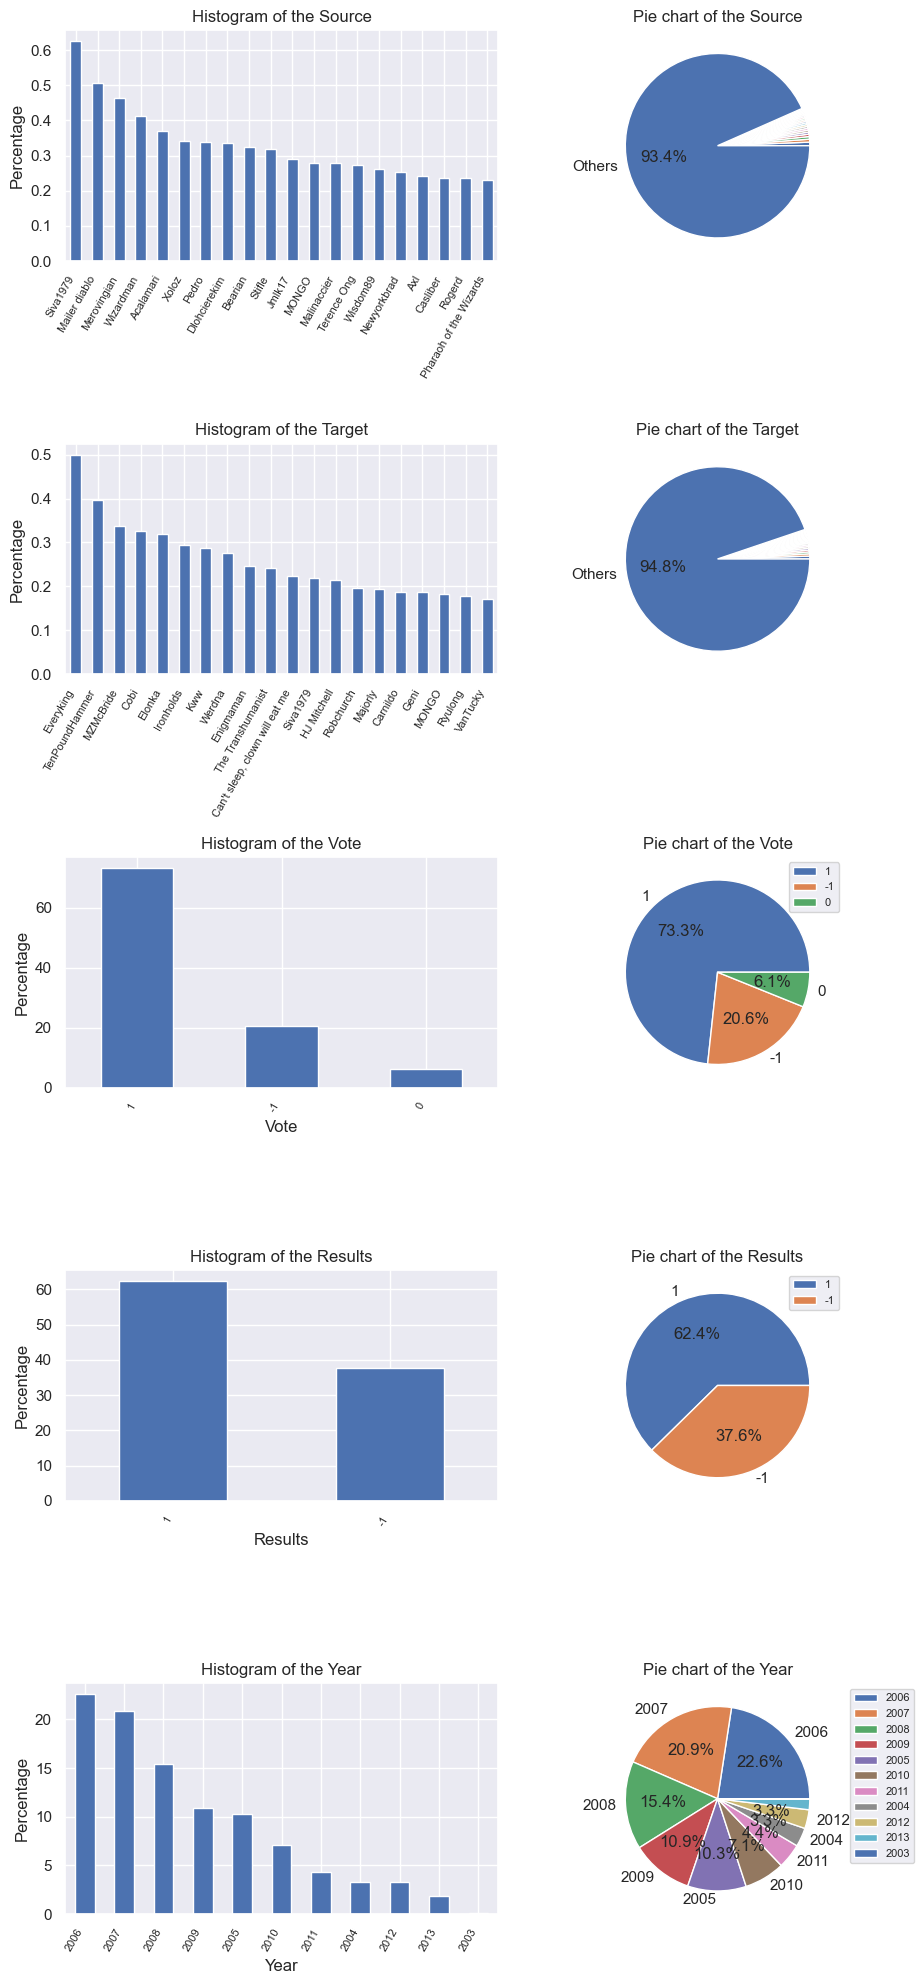

In [97]:
categorical_cols = ['Source', 'Target']
value_cols = ['Vote', 'Results', 'Year']
all_cols = categorical_cols + value_cols
n_top = 20
fig, axes = plt.subplots(len(all_cols), 2, figsize=(10,4*len(all_cols)))
for i, col in enumerate(all_cols):
    ax1 = axes[(2*i) // 2, (2*i) % 2]
    ax2 = axes[(2*i+1) // 2, (2*i+1) % 2]
    data = df[~df[col].isna()]
    if col in categorical_cols:
        top_n = pd.Series(data[col].value_counts().iloc[:n_top])
        others = pd.Series(data[col].value_counts().iloc[n_top:].sum(), index=['Others'])
        value_counts = pd.concat([top_n, others])
        
    elif col in value_cols:
        value_counts = data[col].value_counts()
    
    value_counts = 100*value_counts/np.sum(value_counts)
    labels = value_counts.index.to_list()

    # Count plot
    chart = value_counts[value_counts.index != 'Others'].plot(kind='bar', ax=ax1) 
    chart.set_xticklabels(chart.get_xticklabels(), rotation=60, horizontalalignment='right', fontsize = 8)
    ax1.set_title('Histogram of the ' + col)
    ax1.set_ylabel('Percentage')
    
    # Pie chart
    wedges, texts, autotexts = ax2.pie(value_counts, labels = labels, autopct='%1.1f%%')
    threshold = 2
    for label, pct_label in zip(texts, autotexts):
        pct_value = pct_label.get_text().rstrip('%')
        if float(pct_value) < threshold:
            label.set_text('')
            pct_label.set_text('')
    
    #if too much labels, don't show legend
    if len(labels) < 12:
        ax2.legend(bbox_to_anchor=(1.05, 1), fontsize = 8)
    ax2.set_title('Pie chart of the ' + col)

fig.tight_layout()    
plt.show()

# 3.1 Time series and election rounds computations <a class="anchor" id="time_series"></a>
### Create and describe the time series <a class="anchor" id="ts_creation"></a>
The voting_time series will give the time in minutes at which each vote was cast with respect to the first vote recorded for the same target. We will consider the first vote as the opening time of the polls. Thus for each target we will have a voting time of 0. We print the basic statistic of the time serie.

In [98]:
voting_time = (df.groupby('Target').Date.apply(lambda x: x - x.min()).dt.total_seconds()/3600).rename('Voting_time')

# add voting time to df dataframe, merge on index
df_timeserie = df.join(voting_time.droplevel(0))

# Convert Vote, Results and Year to int
df_timeserie['Vote'] = df_timeserie['Vote'].astype(int)
df_timeserie['Results'] = df_timeserie['Results'].astype(int)
df_timeserie['Year'] = df_timeserie['Year'].astype(int)

# Plot basic statistics
df_timeserie['Voting_time'].describe().round(2)

count    187998.00
mean       1924.74
std        5943.52
min           0.00
25%          10.50
50%          46.80
75%         157.97
max       72598.02
Name: Voting_time, dtype: float64

### 3.2 Handle missing dates <a class="anchor" id="missing_dates"></a>

In [99]:
# Targets where all voting times are NaN
nan_target = set(df_timeserie.Target.unique()) - set(df_timeserie[~df_timeserie['Voting_time'].isna()].Target.unique())
print('Number of target without time data:', len(nan_target), ', corresponding to', round(len(nan_target)/len(df_timeserie.Target.unique())*100, 2), '% of all targets')
print('Target without time data:', nan_target)

# Amount of NaN values in the voting time column
print('Number of NaN values in the voting time column:', df_timeserie['Voting_time'].isna().sum(), ', corresponding to', round(df_timeserie['Voting_time'].isna().sum()/len(df_timeserie)*100, 2), '% of all values')

Number of target without time data: 23 , corresponding to 0.66 % of all targets
Target without time data: {'Cyan', 'Fantasy', 'Noel', 'Jdforrester', 'Chadloder', 'Zanimum', 'Delirium', 'Craigy144', 'Vsmith', 'wavelab1', 'Feco', 'Mintguy', 'RickK', 'Schneelocke', 'Dori', 'J.J.', 'Talrias', 'Woohookitty', 'Tompagenet', 'Starblind', 'Bishonen', 'CYD', 'Olivier'}
Number of NaN values in the voting time column: 7649 , corresponding to 3.91 % of all values


In [100]:
# Remove NaN values in the voting time column
df_timeserie = df_timeserie[~df_timeserie['Voting_time'].isna()]

### 3.3 Analysis : Distribution of the voting time <a class="anchor" id="ts_analysis"></a>
#### 3.3.1 Histograms <a class="anchor" id="ts_hist"></a>
After having computed the voting time series, we can now plot its histogram. We noticed that the distribution is very skewed to the right so we use a log scale for the x-axis. As we defined the first vote as the opening time of the polls, we have a zero voting time for each target but these values are not relevant for the analysis so we remove them to be able to compute the log scale.

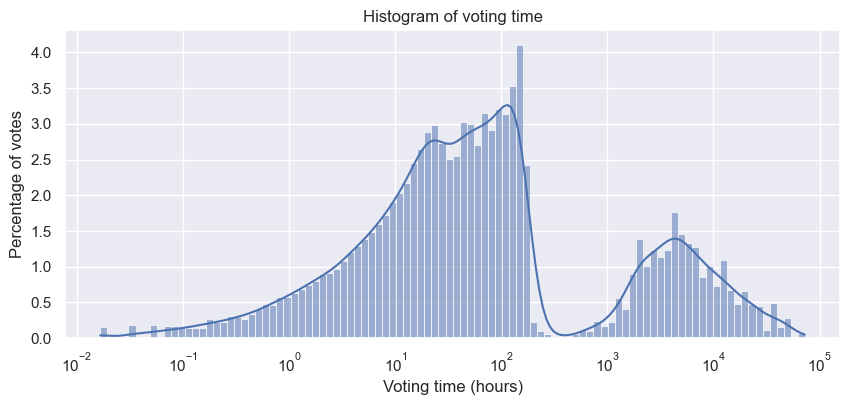

In [101]:
# Remove the vote at time 0 minute, to plot the histogram of voting time
df_plot = df_timeserie[df_timeserie.Voting_time != 0]

fig, ax = plt.subplots(figsize=(10,4))
kde = sns.histplot(data=df_plot, x='Voting_time',kde=True, ax=ax, bins=100, stat='percent', log_scale=(True, False))
ax.set_title('Histogram of voting time')
ax.set_xlabel('Voting time (hours)')
ax.set_ylabel('Percentage of votes')
plt.show()

We get a bi-modal distribution that we will try to explain by plotting the distribution of voting time over the years to see if there is a change in the voting behavior.

#### 3.3.2 Density function over the year <a class="anchor" id="ts_density"></a>

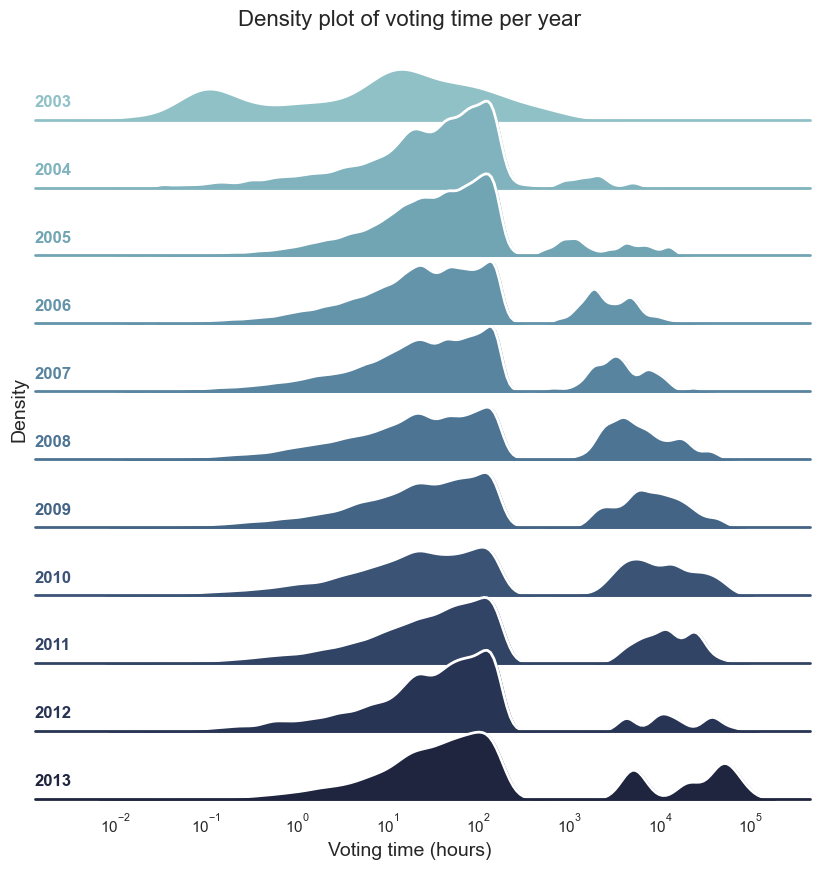

In [102]:
# Ignore warnings for the following plot - change in layout
import warnings 
warnings.filterwarnings('ignore')

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(11, rot=-.25, light=.7)
g = sns.FacetGrid(df_plot, row='Year', hue='Year', aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, 'Voting_time', bw_adjust=.5, clip_on=False, fill=True, alpha=1, linewidth=1.5, log_scale=(True, False))
g.map(sns.kdeplot, 'Voting_time', clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
      ax = plt.gca()
      ax.text(0, .2, label, fontweight="bold", color=color,
                  ha="left", va="center", transform=ax.transAxes)

g.map(label, 'Voting_time')

# Set figure properties
#g.fig.set_tight_layout(True)
g.fig.subplots_adjust(hspace=-.25)
g.fig.set_figwidth(10)
g.fig.set_figheight(10)
g.fig.suptitle('Density plot of voting time per year', fontsize=16, y=0.9)
g.fig.supylabel('Density', fontsize=14, x=0.1)
g.fig.supxlabel('Voting time (hours)', fontsize=14, y=0.05)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel='', xlabel='')
g.despine(bottom=True, left=True)

plt.show()
sns.set_theme()

We can notice at the first glance that in 2003 the voting time distribution was quite different from the other years. Indeed, the voting times were much more spread out and shifted to the left. This is probably due to the fact that at the creation of election system, the rules were not yet well established so the behaviour of the voters was not very consistent. 

#### 3.3.3 Dealing with year 2003 <a class="anchor" id="ts_2003"></a>
We will start by checking if the 2003 data represents a significant part of the data. 

In [103]:
df.Year = df.Year.astype(int)
proportion_2003 = df[df['Year'] == 2003].shape[0] / df.shape[0]
print(f'Proportion of 2003 data: {proportion_2003:.2%}')

Proportion of 2003 data: 0.10%


Knowing that the amount of data for 2003 represents only 0.1% of the total data, we can consider that these data are negligible and we can remove them from the dataset. 

In [104]:
df = df[df['Year'] != 2003]

df_timeserie = df_timeserie[df_timeserie['Year'] != 2003]
# Update the voting time of the df_timeserie dataframe
voting_time = (df_timeserie.groupby('Target').Date.apply(lambda x: x - x.min()).dt.total_seconds()/3600).rename('Voting_time')
df_timeserie = df_timeserie.drop(columns=['Voting_time']).join(voting_time.droplevel(0))

df_plot = df_timeserie[df_timeserie.Voting_time != 0]

### 3.4 Rounds of election <a class="anchor" id="election_rounds"></a>
#### 3.4.1 Time Interval between votes <a class="anchor" id="time_interval"></a>
On another note, we still got a bimodal distribution when plotting the voting time over the year on a log scale (2.3.2) and this is unexpected. Thus and to find an explanation to this phenomenon, we can look at the distribution of time intervals between votes:

In [105]:
# Separate the vote for a candidate by elections rounds
votes_gap = df_timeserie.groupby('Target').Voting_time.apply(lambda x: x.sort_values().diff())
votes_gap.describe()

count    184438.000000
mean         20.277718
std         515.317045
min           0.000000
25%           0.216667
50%           0.716667
75%           2.233333
max       72247.600000
Name: Voting_time, dtype: float64

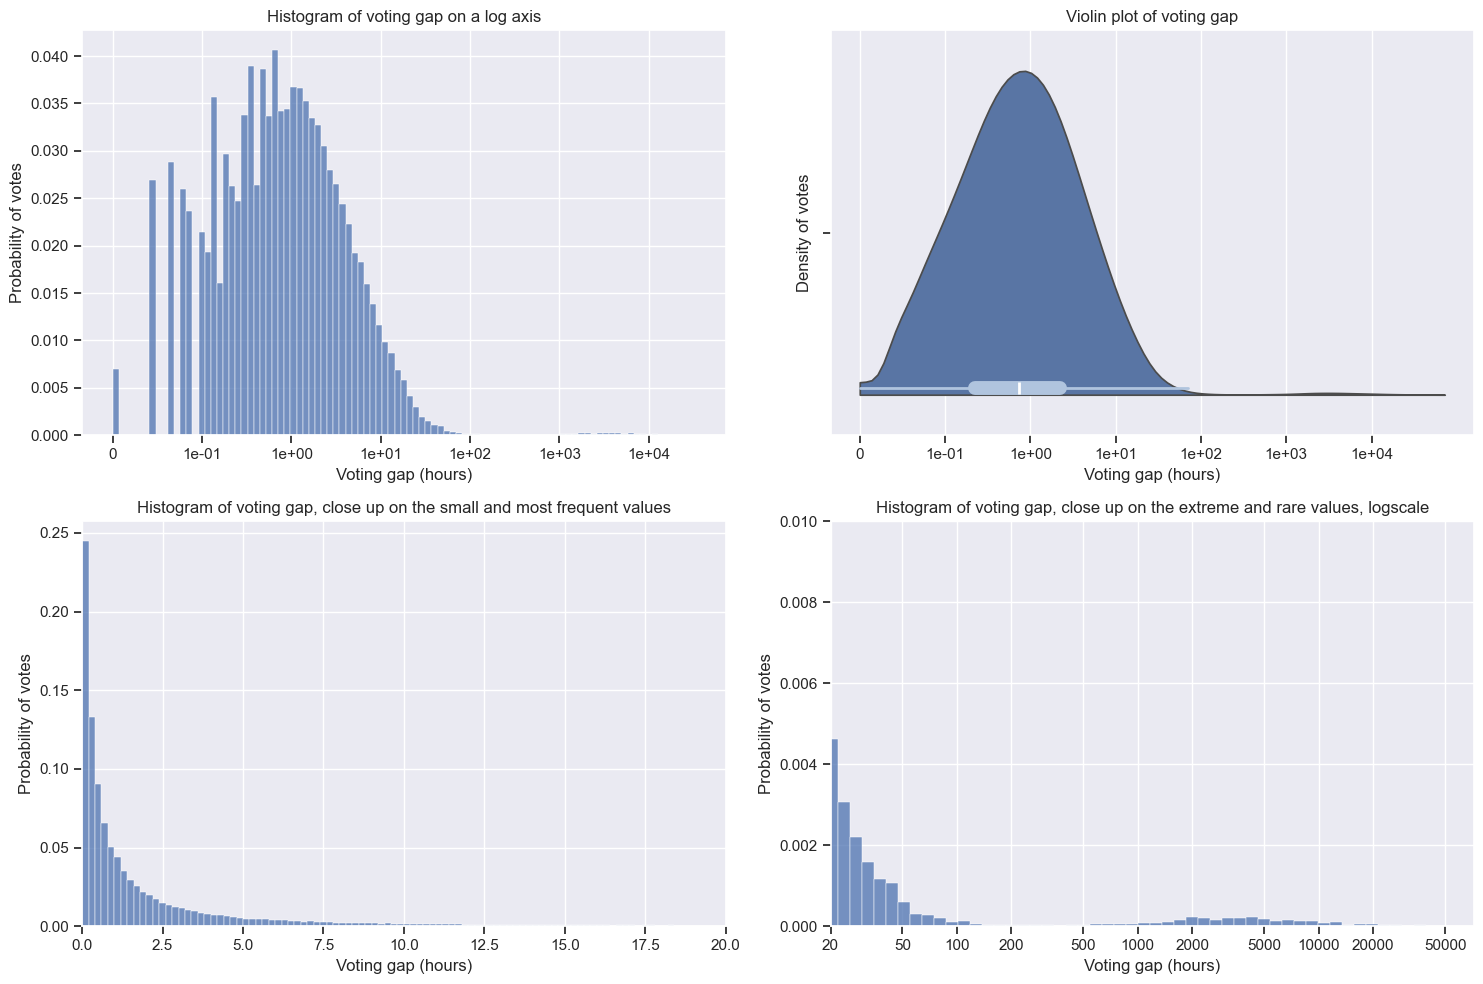

In [106]:
# Plot histograms of voting gap
fig, ax = plt.subplots(2,2, figsize=(15,10), tight_layout=True)

log_shift = 0.01
votes_gap_plot = votes_gap.dropna() + log_shift

# Histogram of the whole distribution on a log x axis
sns.histplot(data=votes_gap_plot, ax=ax[0,0], stat='probability', bins=100, log_scale=(True, False))
ax[0,0].set_title('Histogram of voting gap on a log axis')
ax[0,0].set_xlabel('Voting gap (hours)')
ax[0,0].set_ylabel('Probability of votes')
ax[0,0].tick_params(bottom=True, left=True)
ax[0,0].set_xlim(0, np.max(votes_gap))
ticks = np.power(10, np.arange(np.log10(log_shift), np.ceil(np.log10(np.max(votes_gap_plot))), 1))
labels = [f'{tick:.0e}' for tick in ticks]
labels[0] = '0'
ax[0,0].set_xticks(ticks, labels=labels)

# Violin plot of voting gap
sns.violinplot(data=votes_gap_plot, ax=ax[0,1], orient='h', bw=0.2, cut=0, log_scale=(True, False), split=True, inner_kws=dict(box_width=10, whis_width=2, color="lightsteelblue"))
ax[0,1].set_title('Violin plot of voting gap')
ax[0,1].set_xlabel('Voting gap (hours)')
ax[0,1].set_ylabel('Density of votes')
ax[0,1].tick_params(bottom=True, left=True)
ax[0,1].set_xticks(ticks, labels=labels)

# Histogram of the whole distribution on a log x axis, close up on the small and most frequent values
sns.histplot(data=votes_gap, ax=ax[1,0], stat='probability', bins=100, binrange=(0,20))
ax[1,0].set_title('Histogram of voting gap, close up on the small and most frequent values')
ax[1,0].set_xlabel('Voting gap (hours)')
ax[1,0].set_ylabel('Probability of votes')
ax[1,0].set_xlim(0, 20)
ax[1,0].tick_params(bottom=True, left=True)

# Histogram of the whole distribution on a log x axis, close up on the extreme and rare values
sns.histplot(data=votes_gap, ax=ax[1,1], stat='probability', bins=100, log_scale=(True, False))
ax[1,1].set_title('Histogram of voting gap, close up on the extreme and rare values, logscale')
ax[1,1].set_xlabel('Voting gap (hours)')
ax[1,1].set_ylabel('Probability of votes')
ax[1,1].set_xlim(20, np.max(votes_gap))
ax[1,1].set_ylim(0, 0.01)
ax[1,1].set_xticks([20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000], labels=['20', '50', '100', '200', '500', '1000', '2000', '5000', '10000', '20000', '50000']) 
ax[1,1].tick_params(bottom=True, left=True)

plt.show()

In [107]:
print(f'Extract the voting gap corresponding to the 99% quantile: {votes_gap.quantile(0.99):.2f} hours')

Extract the voting gap corresponding to the 99% quantile: 26.90 hours


We can see that the distribution of the time interval between votes almost follows an exponential distribution (which is confirmed by the violin plot on the upper right corner of the figure that match with a gaussian distribution on log axis), it is what we would expect for this type of data. However, we can see that there is an additional very small peak between 1000 and 20000 hours, which reveals the presence of multiple batches/aggregate of votes separated by a long period of time. 

We interpret this as different rounds of elections. Indeed, some target are not elected at the first try and they run for admin again after a certain period of time. We now want to separate the data into different rounds of elections for each target.

#### 3.4.2 Separate data into rounds of elections <a class="anchor" id="rounds"></a>


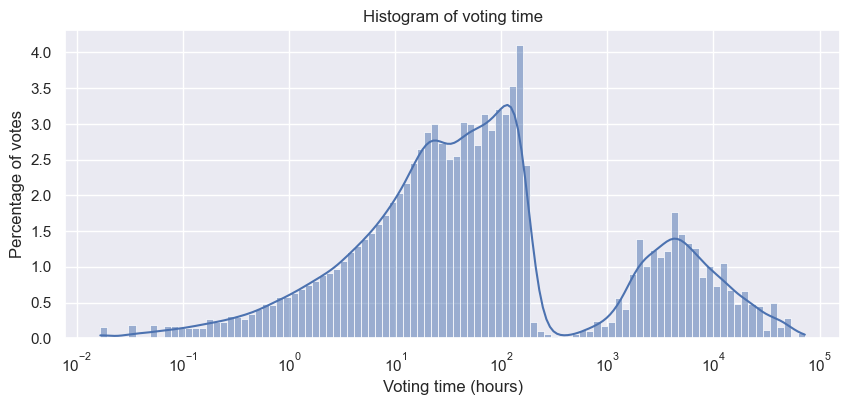

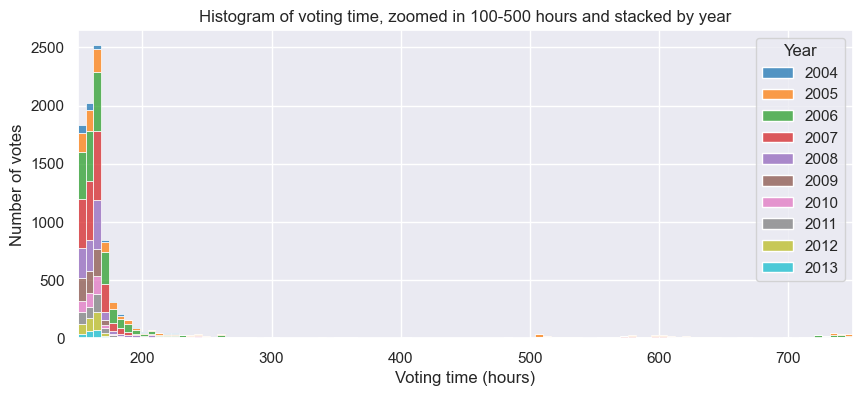

After this threshold in hours, we consider that the incoming votes are part of a new election: 391.11 hours
Percentage of votes happening at this threshold: 0.041%


In [108]:
fig, ax = plt.subplots(figsize=(10,4))
kde = sns.histplot(data=df_plot, x='Voting_time', kde=True, ax=ax, bins=100, stat='percent', log_scale=(True, False))
ax.set_title('Histogram of voting time')
ax.set_xlabel('Voting time (hours)')
ax.set_ylabel('Percentage of votes')
plt.show()

# Close up the voting time to 100-500 hours
fig, ax = plt.subplots(figsize=(10,4))
sns.histplot(data=df_plot, x='Voting_time', ax=ax, bins=100, stat='count', log_scale=(False, False), binrange=(150, 750), hue='Year', palette='tab10', multiple='stack')
ax.set_title('Histogram of voting time, zoomed in 100-500 hours and stacked by year')
ax.set_xlabel('Voting time (hours)')
ax.set_ylabel('Number of votes')
ax.set_xlim(150, 750)
plt.show()

# Fin the local minima
kde = kde.get_lines()[0].get_data()
deriv_kde_sign = np.sign(np.diff(kde[1]))
local_mins = kde[0][np.append((np.roll(deriv_kde_sign, 1) - deriv_kde_sign) != 0, False)]
y_mins = kde[1][np.append((np.roll(deriv_kde_sign, 1) - deriv_kde_sign) != 0, False)]

# only keep the minima with a y value < 0.1 and a x value is between 10 and 1e4
round_threshold = local_mins[(y_mins < 0.1) & (local_mins > 10) & (local_mins < 1e3)][0]
percent_at_threshold = y_mins[(y_mins < 0.1) & (local_mins > 10) & (local_mins < 1e3)][0]

print(f'After this threshold in hours, we consider that the incoming votes are part of a new election: {round_threshold:.2f} hours')
print(f'Percentage of votes happening at this threshold: {percent_at_threshold:.2}%')

To separate the different rounds of elections we focus on the gap between the 2 peaks in the distribution of voting time. First, we can observe that there is a huge drop in the amount of votes at around 170h which is consistent with the information we found on the Wikipedia page about the election duration being approximately 7 days (noting that this period can be prolonged in some cases). 

To find the best threshold to separate the data, we extracted the kernel density estimation of the distribution of voting time and we computed its local minimum in the gap between the 2 peaks and the corresponding voting time. We found that the best threshold to separate the data is 391h. We can now separate the data into different rounds of elections for each target using this threshold.

In [109]:
rounds = (df_timeserie.groupby('Target').apply(lambda x: hlp.compute_rounds(x, round_threshold))).rename('Round')
df_timeserie = df_timeserie.join(rounds.droplevel(0))
df_timeserie.sample(3)

,Source,Target,Vote,Results,Year,Date,Comment,Voting_time,Round
18541,Worm That Turned,WikiCopter,0,-1,2011,2011-03-07 08:51:00,Almost bang on 6 months after [[Wikipedia:Requ...,4205.500000,2
56000,Naerii,Buckshot06,1,1,2008,2008-09-28 16:38:00,''',1.950000,1
190857,Hedley,Uncle G,0,-1,2005,2005-04-09 18:22:00,"Would like to see the user get a user page, an...",7.616667,1


The function we use to separate the data into different rounds of elections deal with some special cases, namely:
- If the result is true then we assign the subsequent votes to the same round of election
- Exception to the previous rule: if new votes are cast after a period of more than 4 months, we consider that it is a new round of election (we found that some targets previously elected were running for admin again when an incident happened)
- If a vote is cast less than 24h after the previous one, we consider that it is part of the same round of election (sometimes the election is prolonged)
- The time threshold for a round is computed starting from the second vote of the round because some times there is a delay between the creation of the polls (that open with the first vote) and the next vote  

#### 3.4.3 Updating the voting time with respect to election rounds <a class="anchor" id="election_times"></a>

In [110]:
# Use the round number to compute the voting time in each round (i.e. the time between the current vote and the first vote of the round)
Voting_time_round = df_timeserie.groupby(['Target', 'Round']).Voting_time.apply(lambda x: x - x.min())
# Replace the column Voting_time by the voting time in each round
df_timeserie = df_timeserie.drop(columns='Voting_time').join(Voting_time_round.droplevel([0,1]))
df_plot = df_timeserie[df_timeserie.Voting_time != 0]
df_timeserie.sample(3)

,Source,Target,Vote,Results,Year,Date,Comment,Round,Voting_time
20199,Kudpung,Dabomb87,1,1,2010,2010-08-17 14:05:00,"Oh alright, Sandy, I've been hovering here wit...",1,19.700000
6945,Shawn in Montreal,Σ,1,-1,2012,2012-10-05 19:28:00,'''Support''' <s>(changed to neutral)</s> Whil...,1,89.766667
584,Salvio giuliano,Jason Quinn,1,1,2013,2013-01-27 20:29:00,"Basically, I trust you. That's why I ended up ...",2,64.983333


Now that we have separated the data into different rounds of elections for each target, we update the voting time with respect to the first vote of each round of election. We can now plot the distribution of voting time on a log scale (we stack the data for each year) and we can see that the bimodal distribution disappeared and we get a unimodal distribution which is what we would expect for this type of data.

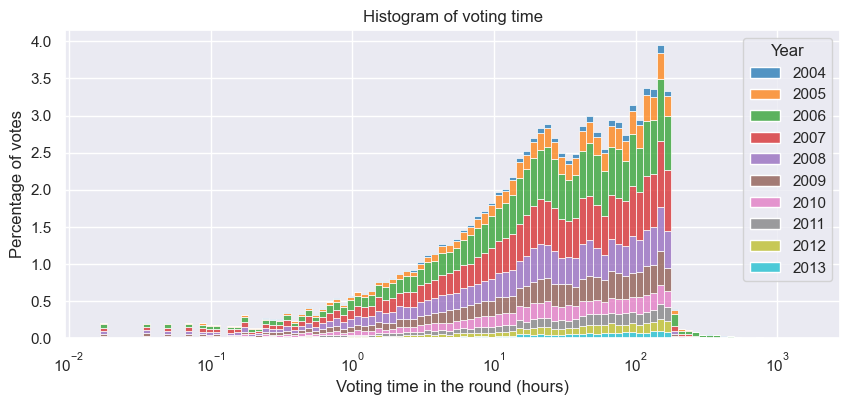

In [111]:
fig, ax = plt.subplots(figsize=(10,4))
kde = sns.histplot(data=df_plot, x='Voting_time', ax=ax, bins=100, stat='percent', log_scale=(True, False), hue='Year', palette='tab10', multiple='stack')
ax.set_title('Histogram of voting time')
ax.set_xlabel('Voting time in the round (hours)')
ax.set_ylabel('Percentage of votes')
plt.show()

#### Save the preprocessed DataFrame for the time serie

In [112]:
df_timeserie.to_csv('wiki-RfA_timeserie.csv')

### 4. Votes evolution through time <a class="anchor" id="votes_evolution"></a>
We now want to investigate the evolution of votes given the voting time. First, we want to see how the proportion of votes changes over time and to do so we start by computing the average vote after each new entry. 

In [113]:
#saving previous work.
df_vote_evolution = df_timeserie.copy()

progressive_mean = df_vote_evolution.groupby(['Target', 'Round']).apply(lambda x: x.Vote.cumsum() / np.arange(1, len(x)+1)).rename('progressive_mean')

# Replace the column Vote by the progressive mean
df_vote_evolution = df_vote_evolution.join(progressive_mean.droplevel([0,1]))
df_vote_evolution.sample(3)

,Source,Target,Vote,Results,Year,Date,Comment,Round,Voting_time,progressive_mean
187351,Alan Au,Ben Arnold,-1,-1,2005,2005-08-31 22:09:00,'''Oppose'''. It's great to have editors that...,1,19.066667,0.25
112183,Keepscases,Bobes66,-1,-1,2007,2007-11-27 19:20:00,'''Oppose''',1,0.050000,-1.00
141848,Searchme,Metamagician3000,1,1,2006,2006-05-03 03:30:00,'''Support''',1,23.100000,1.00


In [114]:
# Convert the voting time into time deltas.
df_vote_evolution.Voting_time = pd.to_timedelta(df_vote_evolution.Voting_time, unit='h')
df_vote_evolution.sort_values('Voting_time', inplace=True)
display(df_vote_evolution.sample(3))

,Source,Target,Vote,Results,Year,Date,Comment,Round,Voting_time,progressive_mean
85882,Bucketsofg,AndonicO,1,1,2007,2007-04-24 19:16:00,'''Support'''.,1,9 days 01:43:00.000000001,1.0
140226,Joturner,Laurascudder,1,1,2006,2006-03-20 20:44:00,'''Support''' Sure; seems like a good editor w...,1,0 days 00:19:59.999999998,1.0
4266,Pdcook,Crisco 1492,1,1,2012,2012-05-30 13:49:00,'''Support''' - No concerns. A very good editor.,1,3 days 02:58:59.999999998,1.0


We want to investigate the difference of votes over time for the successful and unsuccessful elections (Result = -1 or 1). To do so, we compute the moving average of the progressive mean for the successful and unsuccessful elections separately. 

In [115]:
rolling_avg = df_vote_evolution.groupby('Results').rolling('1h', on='Voting_time').progressive_mean.aggregate(['mean', 'std']).reset_index(level='Voting_time')
rolling_avg.Voting_time = rolling_avg.Voting_time.dt.total_seconds()/3600
display(rolling_avg.sample(3))

,Voting_time,mean,std
Results,,,
-1,0.000000,0.221125,0.843808
-1,27.866667,0.584841,0.519034
1,88.333333,0.979772,0.078692


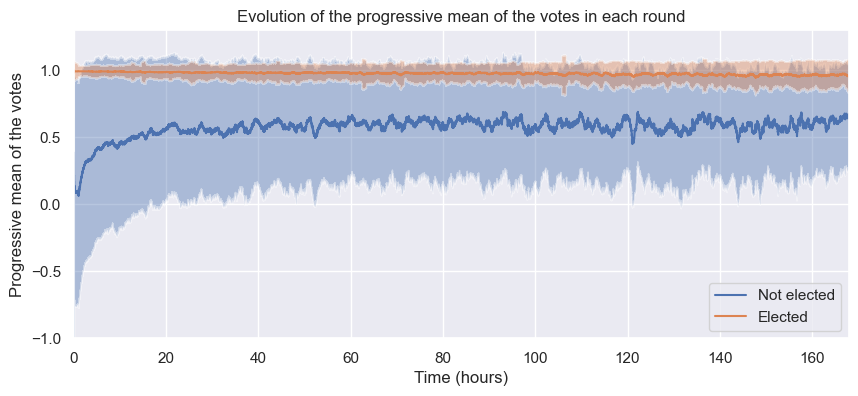

In [116]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(rolling_avg.loc[-1].Voting_time, rolling_avg.loc[-1]['mean'], label='Not elected')
ax.fill_between(rolling_avg.loc[-1].Voting_time, rolling_avg.loc[-1]['mean']-rolling_avg.loc[-1]['std'], rolling_avg.loc[-1]['mean']+rolling_avg.loc[-1]['std'], alpha=0.4)
ax.plot(rolling_avg.loc[1].Voting_time, rolling_avg.loc[1]['mean'], label='Elected')
ax.fill_between(rolling_avg.loc[1].Voting_time, rolling_avg.loc[1]['mean']-rolling_avg.loc[1]['std'], rolling_avg.loc[1]['mean']+rolling_avg.loc[1]['std'], alpha=0.4)
ax.set_title('Evolution of the progressive mean of the votes in each round')
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Progressive mean of the votes')
ax.set_xlim(0, 24*7)
ax.set_ylim(-1, 1.3)
ax.legend(loc='lower right')
plt.show()  

Based on the plot above, we noticed a clear difference in the variation of the votes over time between the successful and unsuccessful elections. Indeed, we can see that the average vote for the successful elections is much more stable than the unsuccessful ones. Moreover and interestingly for the rest of our project we can also see the behavior for the early vote are drastically different for both groups and needs to be further invesigate.  

# 5. Dive into on the Sources <a class="anchor" id="source"></a>
### 5.1 Distribution of the source voting <a class="anchor" id="source_distrib"></a>

In [117]:
df_source = df.copy(deep=True)
#Artifact from the merge of code but for this part we need to interpret the Vote as integer
df_source.Vote = df_source.Vote.astype(int)

First we get a glance at the proportion of distinct source by year in comparison with the total number of sources overall.

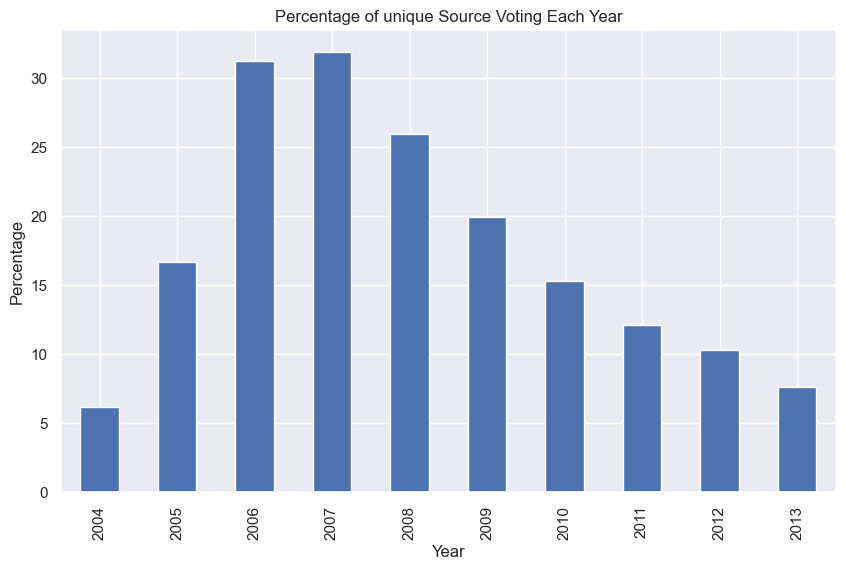

In [118]:
# Calculate the distribution of the source over the year
source_percentage = df_source.groupby('Year')['Source'].nunique() / len(df_source.Source.unique())*100

# Plotting
source_percentage.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Percentage of unique Source Voting Each Year')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.show()

For each year we consider we take the average of the percentage of unique source that vote for a target. It gives us an indicator of the proportion of source participating in average. 

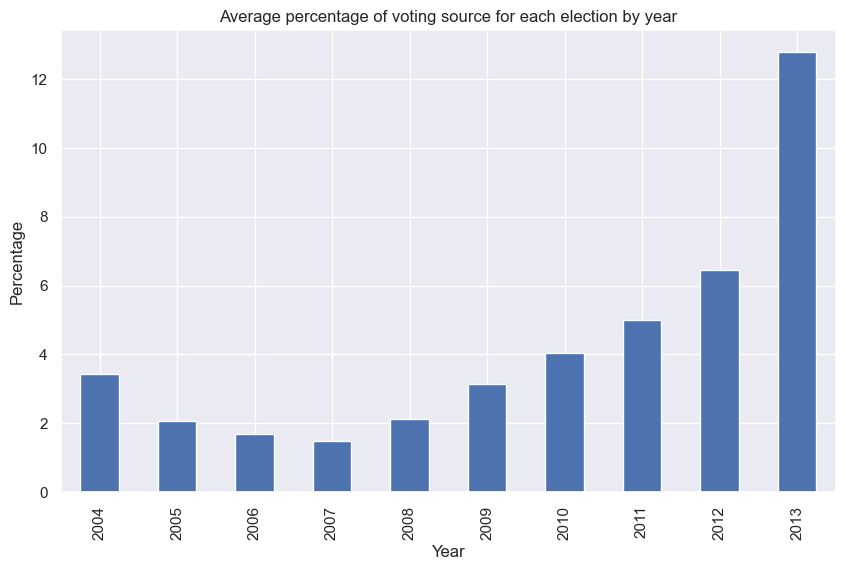

In [119]:
d={}
year_index = range(2004, 2014)
for i in year_index:
  df_sub = hlp.select_year(df_source, i)
  nb_source =  len(df_sub.Source.unique())
  percent_by_target = df_sub.groupby('Target')['Source'].nunique()/nb_source*100
  d.update({i:percent_by_target.mean()})

election_source_percentage = pd.Series(data=d, index=year_index)

election_source_percentage.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Average percentage of voting source for each election by year')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.show()

To have a "baseline" for the distribution of all votes we plot the count of votes for each year.

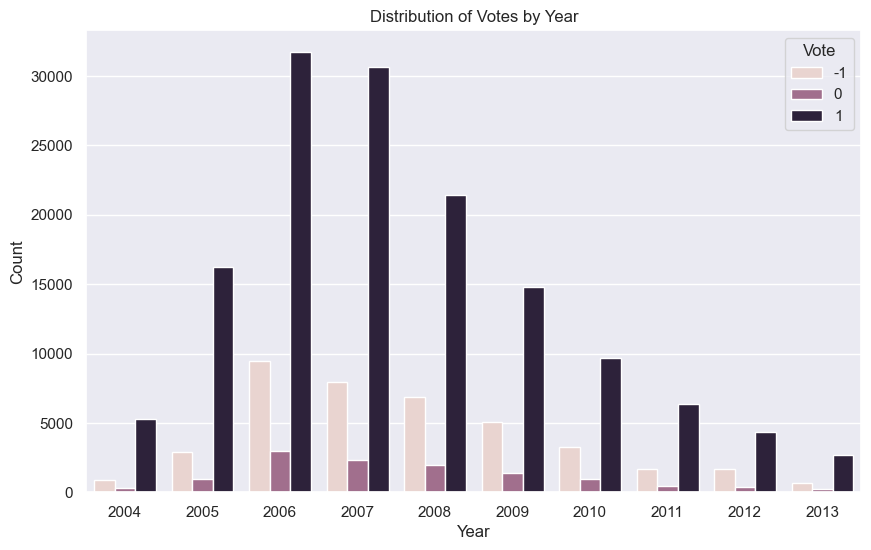

In [120]:
# Create a count plot
plt.figure(figsize=(10, 6))
sns.countplot(x='Year', hue='Vote', data=df_source)
plt.title('Distribution of Votes by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Vote', loc='upper right', labels=['-1', '0', '1'])
plt.show()

We can see that the trends of the proportion of different sources voting for at least one election by year and the average proportion of different soucres voting for specific vote is inversed.

On the other hand we can see that the proportion of different sources voting for at least one election is follwing the number of votes which seems fair. 

# 6. Community Extraction based on similar vote for Targets <a class="anchor" id="community"></a>
We will use Louvain and Leiden algorithm, the second one beeing an improvement of the first: https://www.nature.com/articles/s41598-019-41695-z.

More on the implementation here: https://readthedocs.org/projects/leidenalg/downloads/pdf/latest/


In the first two subparts below we consider the Graph composed of:
 - Sources and Targets as Vertices
 - Vote of the given type as (undirected) Edges - for each algorithm we consider each type of vote (-1,0,1) in seperated Graph

Also please note that in this part we did not discareded the 2003 year yet. If in the following of this project, it relevant to do so we will do it.

In [121]:
import igraph as ig 
import leidenalg as la

### 6.1 Louvain Algorithm <a class="anchor" id="louvain"></a>
Create the community based on the Louvain algorithm. 

In [122]:
#Create a new DataFrame to hold the community data
columns = ['Year', 'Vote', 'Total nbr of community', 'Size of each community', 'Community members']
df_community=pd.DataFrame(columns=columns)

wiki_RfA_df = pd.read_csv('wiki-RfA.csv', index_col=0, parse_dates=['Date'])

#Extracts the community of a given year and vote
years=wiki_RfA_df['Year'].unique()
for n, year in enumerate(years):
    G_community_pos = hlp.extract_community_louvain(wiki_RfA_df, year,1)
    size_communities_pos = hlp.compute_com_size(G_community_pos)
    df_community.loc[3*n] = [year, 1, len(size_communities_pos), size_communities_pos, G_community_pos]
    
    G_community_neg = hlp.extract_community_louvain(wiki_RfA_df, year,-1)
    size_communities_neg = hlp.compute_com_size(G_community_neg)
    df_community.loc[3*n+1] = [year, -1, len(size_communities_neg), size_communities_neg, G_community_neg]
    
    G_community_neu = hlp.extract_community_louvain(wiki_RfA_df, year,0)
    size_communities_neu = hlp.compute_com_size(G_community_neu)
    df_community.loc[3*n+2] = [year, 0, len(size_communities_neu), size_communities_neu, G_community_neu]

df_community.sample(3)


,Year,Vote,Total nbr of community,Size of each community,Community members
2,2013,0,13,"[12, 13, 16, 10, 22, 8, 15, 12, 3, 11, 15, 2, 15]","[{Tyrol5, Atama, Ypnypn, Pol430, Tucoxn, Beebl..."
22,2006,-1,14,"[148, 172, 4, 2, 3, 2, 486, 54, 5, 436, 51, 31...","[{Nrcprm2026, Goldom, Fair Deal, GIen, RGTrayn..."
17,2008,0,26,"[80, 2, 2, 79, 2, 2, 3, 52, 11, 2, 33, 3, 40, ...","[{Metros, Rudget, TheBlazikenMaster, Sjakkalle..."


Plots the number of community per year and type of vote.

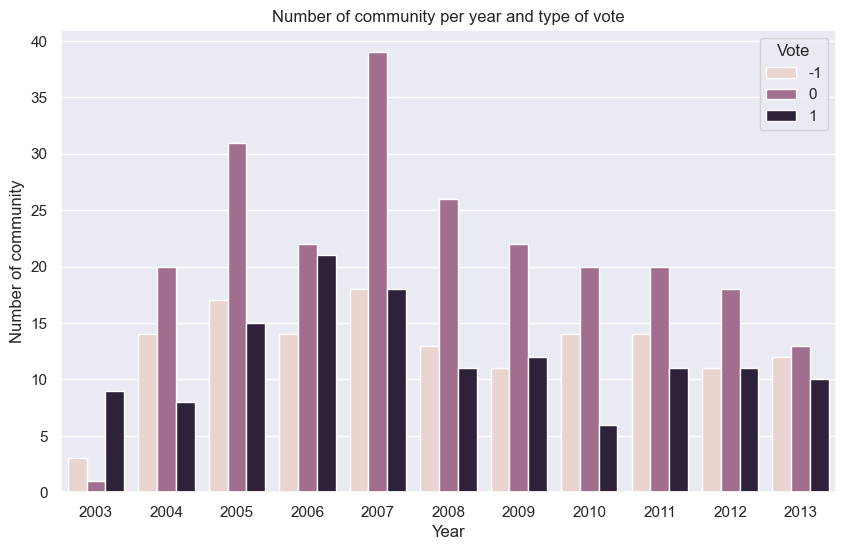

In [123]:
sns.barplot(data=df_community[['Year', 'Vote', 'Total nbr of community']], x='Year', y='Total nbr of community', hue='Vote')

sns.set(rc={'figure.figsize':(10, 6)})
plt.title('Number of community per year and type of vote')
plt.xlabel('Year')
plt.ylabel('Number of community')
plt.show()

### 6.2 Leiden Algorithm <a class="anchor" id="leiden"></a>
Create the communities using the Leiden algorithm.

In [124]:
columns_ = ['Year', 'Vote', 'Total nbr of community', 'Size of each community']
df_community_leiden=pd.DataFrame(columns=columns_)

years=wiki_RfA_df['Year'].unique()
for n, year in enumerate(years):
    partition_pos = hlp.extract_community_leiden(wiki_RfA_df, year,1)
    features_pos = hlp.compute_partition_features(partition_pos)
    df_community_leiden.loc[3*n] = [year, 1, features_pos[0], features_pos[1]]

    partition_neg = hlp.extract_community_leiden(wiki_RfA_df, year,-1)
    features_neg = hlp.compute_partition_features(partition_neg)
    df_community_leiden.loc[3*n+1] = [year, -1, features_neg[0], features_neg[1]]

    partition_neu = hlp.extract_community_leiden(wiki_RfA_df, year,0)
    features_neu = hlp.compute_partition_features(partition_neu)
    df_community_leiden.loc[3*n+2]=[year, 0, features_neu[0], features_neu[1]]

df_community_leiden.sample(3)

,Year,Vote,Total nbr of community,Size of each community
24,2004,1,7,"[193, 117, 79, 17, 4, 3, 2]"
3,2012,1,7,"[213, 210, 117, 66, 49, 48, 2]"
18,2007,1,19,"[1028, 788, 145, 78, 33, 27, 17, 12, 4, 3, 2, ..."


Plots the number of community per year and type of vote.

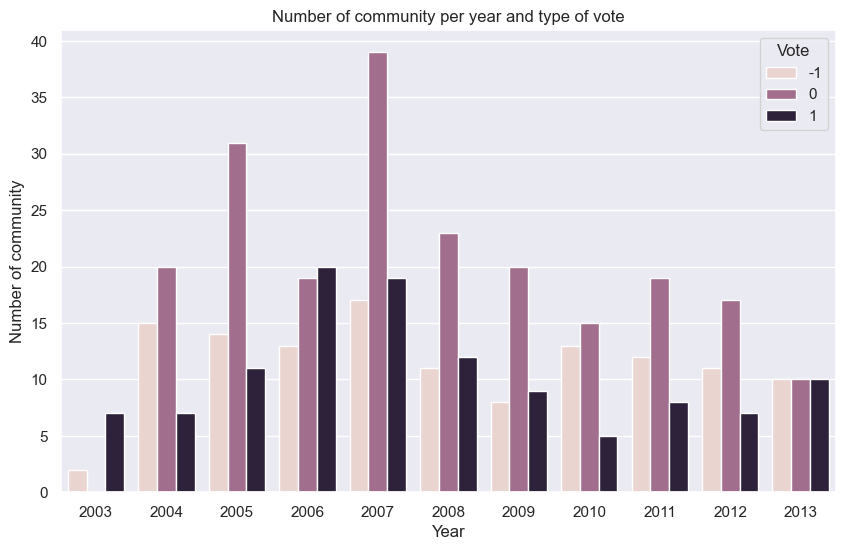

In [125]:
sns.barplot(data=df_community_leiden[['Year', 'Vote', 'Total nbr of community']], x='Year', y='Total nbr of community', hue='Vote')

plt.title('Number of community per year and type of vote')
plt.xlabel('Year')
plt.ylabel('Number of community')
plt.show()

### 6.3 Leiden and Louvain algorithm comparison <a class="anchor" id="comparison_algo"></a>

We saw that the Leiden algorithm is an optimised version of the Louvain algorithm we used previously. We want to quantify how much different these two algorithms are in our data. To do that we will look at the relative difference in percentage between the 2 algorithms for each year and per vote category. 

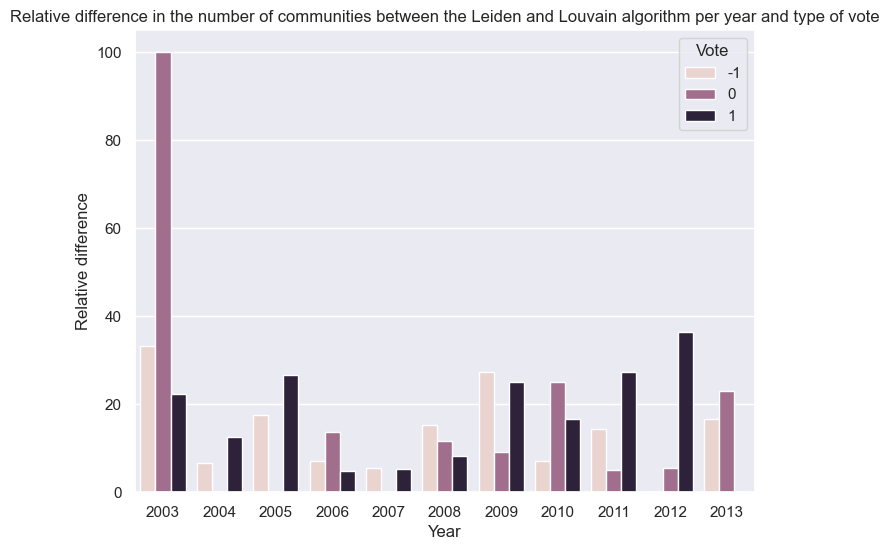

In [126]:
result_df = pd.DataFrame({'Year': df_community_leiden['Year'],
                           'Vote': df_community_leiden['Vote'],
                           'Difference': (df_community['Total nbr of community'] - df_community_leiden['Total nbr of community']).abs()/np.max((df_community['Total nbr of community'],df_community_leiden['Total nbr of community']), axis=0)*100 })

fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(data=result_df[['Year', 'Vote', 'Difference']], x='Year', y='Difference', hue='Vote')

plt.title('Relative difference in the number of communities between the Leiden and Louvain algorithm per year and type of vote')
plt.xlabel('Year')
plt.ylabel('Relative difference')
plt.show()

In general, we can see that both algorithms differ in the number of communities they formed, sometimes significantly (100% for 2003 and neutral vote). 


In the following we look more precisely at the number of communities for each algorithm to be able to better understand where such large differences for some years and vote type come from.  

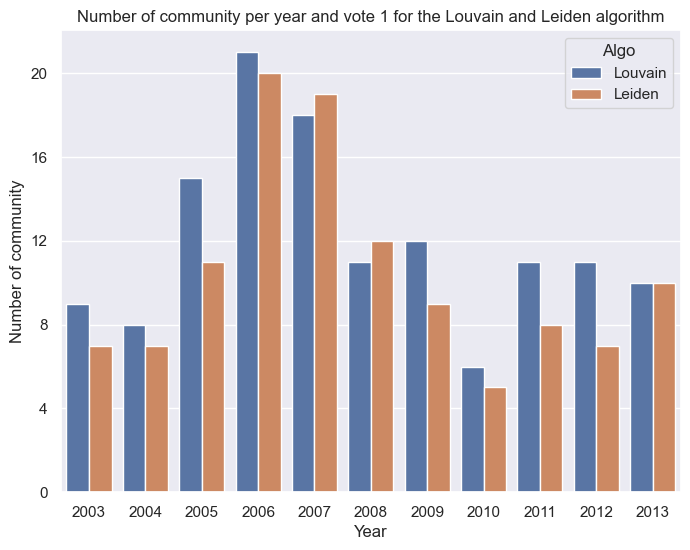

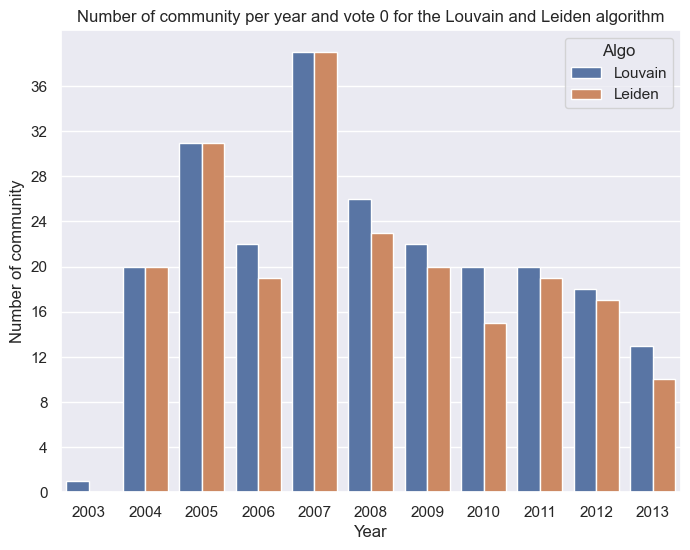

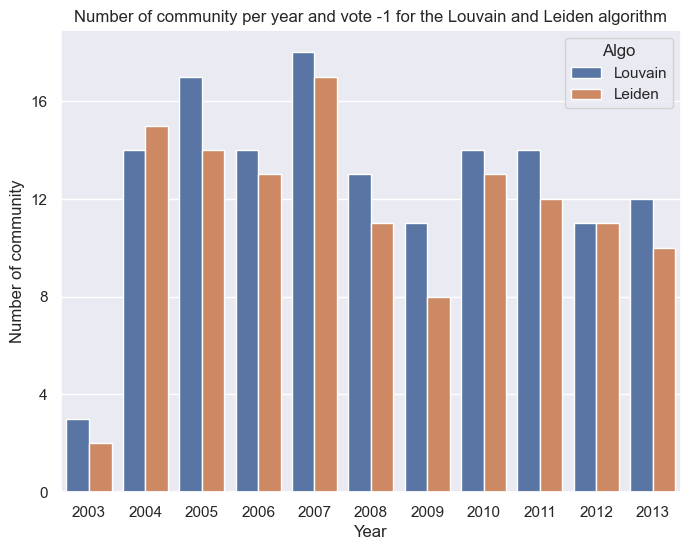

In [127]:
#Plot the graph for the 3 types of vote
hlp.plot_comparaison_leiden_louvain_per_type_vote(1, df_community, df_community_leiden)
hlp.plot_comparaison_leiden_louvain_per_type_vote(0, df_community, df_community_leiden)
hlp.plot_comparaison_leiden_louvain_per_type_vote(-1, df_community, df_community_leiden)

As we've seen in the previous plot, we have some variations in the number of community: often few (for example in 2004 for all vote type) but sometimes more (for instance in 2007 and positive vote). This graphs allows us to explain the 100% relative difference for 2003 on neutral vote. Indeed, the Louvain algorithm found one community whereas Leiden algorithm found none which results in a relative difference of 1 and a percentage of 100%.

In general, we can see some variation between the 2 algorithms. Even if the paper mentioned before certifies that Leiden algorithm is more optimized, further analysis need to be conducted to determine the most appropriate algorithm on our data if we want to build communities. 

### 6.4 Directed Graph <a class="anchor" id="directed_graph"></a>

Until now we extracted communities based on a non directed graph between Source and Target in term of positive, neutral or negative vote. However, considering that the link goes in both way is not that accurate with the data we have. Indeed, we know that a Source voted for a Target but we don't know the interaction a Target has fro a Source. Taking that into account, our graph needs to be directed such that it maps this unilateral interaction. We will look at how directed graph impact our result using Leiden algorithm (indicated as better in the paper cited before)

In [128]:
#create the dataframe
columns_ = ['Year', 'Vote', 'Total nbr of community', 'Size of each community']
df_community_leiden_directed=pd.DataFrame(columns=columns_)

years=wiki_RfA_df['Year'].astype('int').unique()
for n, year in enumerate(years):
    partition_pos=hlp.extract_community_leiden_directed(wiki_RfA_df, year,1)
    features_pos=hlp.compute_partition_features(partition_pos)
    df_community_leiden_directed.loc[3*n]=[year, 1, features_pos[0], features_pos[1]]

    partition_neg=hlp.extract_community_leiden_directed(wiki_RfA_df, year,-1)
    features_neg=hlp.compute_partition_features(partition_neg)
    df_community_leiden_directed.loc[3*n+1]=[year, -1, features_neg[0], features_neg[1]]

    partition_neu=hlp.extract_community_leiden(wiki_RfA_df, year,0)
    features_neu=hlp.compute_partition_features(partition_neu)
    df_community_leiden_directed.loc[3*n+2]=[year, 0, features_neu[0], features_neu[1]]

df_community_leiden_directed.sample(3) 

,Year,Vote,Total nbr of community,Size of each community
19,2007,-1,15,"[407, 307, 261, 131, 111, 80, 79, 32, 25, 5, 2..."
5,2012,0,17,"[31, 22, 22, 20, 19, 17, 17, 17, 15, 12, 12, 7..."
12,2009,1,7,"[422, 417, 365, 282, 2, 2, 1]"


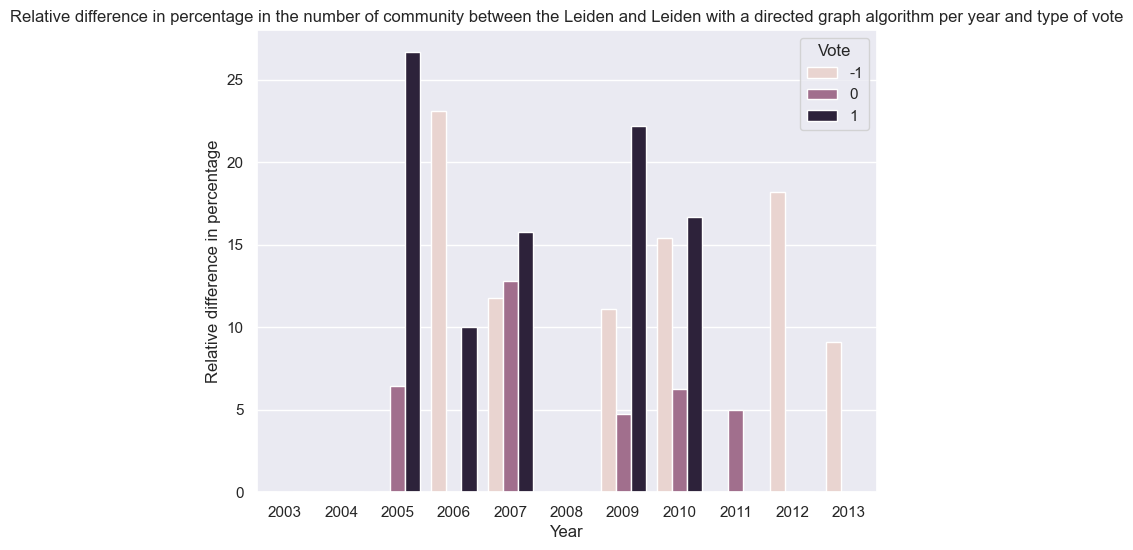

In [129]:
comparison_directed_df = pd.DataFrame({'Year': df_community_leiden_directed['Year'],
                           'Vote': df_community_leiden_directed['Vote'],
                           'Difference': (df_community_leiden_directed['Total nbr of community'] - df_community_leiden['Total nbr of community']).abs()/np.max((df_community_leiden_directed['Total nbr of community'],df_community_leiden['Total nbr of community']), axis=0)*100 })

fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(data=comparison_directed_df[['Year', 'Vote', 'Difference']], x='Year', y='Difference', hue='Vote')

plt.title('Relative difference in percentage in the number of community between the Leiden and Leiden with a directed graph algorithm per year and type of vote')
plt.xlabel('Year')
plt.ylabel('Relative difference in percentage')
plt.show()

Looking at this graph, we can see that for some years and vote, we do not have any difference between the Leiden algorithm on a non directed and directed graph: it is the case for 2003 all votes and 2010 for positive and neutral vote for instance. For a large majority of comparison there is a difference between the 2. It is smaller than when we compared Louvain and Leiden non directed graph algorithms but still a difference. It means that adding direction to our graph has indeed an impact and we would need to take it into account in the commnunity algorithm we will use in the next steps of our project

# 7. Comments Analysis <a class="anchor" id="comments"></a>
### 7.1 Information Extractions from Comments <a class="anchor" id="info_extraction"></a>

As in the previous part we will start over with less processed dataset.

In [130]:
df_comment = pd.read_csv('wiki-RfA.csv', index_col=0, parse_dates=['Date'])

#Parse the comments to a new column
df_comment['Comment'] = df_comment['Comment'].apply(lambda x: [] if pd.isna(x) else x)
df_comment["Parsed_Comment"] = df_comment.Comment.apply(lambda x: mwparserfromhell.parse(x).strip_code())

#Initialize a dataframe containing only relevant info for futur comment analysis
stat_df = pd.DataFrame(columns = ['Source','Vote', 'Comment', 'Parsed_Comment'])
stat_df['Vote']=df_comment['Vote']
stat_df['Source']=df_comment['Source']
stat_df['Comment'] = df_comment['Comment']
stat_df['Parsed_Comment']=df_comment['Parsed_Comment']

Count the number of word occurrences without taking into account "stopwords" (the, and, me...) from the comment language: english.


In [131]:
vectorizer = CountVectorizer(stop_words='english')
stat_df['Vectorized_Comment'] = stat_df['Parsed_Comment'].apply(lambda x: vectorizer.build_analyzer()(x)) 
stat_df['Vector_Size'] = stat_df['Vectorized_Comment'].apply(lambda x: len(x))
stat_df.sample(3)

,Source,Vote,Comment,Parsed_Comment,Vectorized_Comment,Vector_Size
56181,John254,1,'''Support''',Support,[support],1
178029,The Minister of War,1,'''Support'''. What would the world be without...,Support. What would the world be without janit...,"[support, world, janitors, like, word, ahoy]",6
192436,Texture,1,[[User:Texture|<font color=red>T&#949;x</font>...,Tεxτ,[tεxτ],1


### 7.2 Some Statistics about Comments <a class="anchor" id="comments_distrib"></a>

In [132]:
print(f'The minimum length of the comment is: {np.min(stat_df["Vector_Size"]):.2f}')
print(f'The maximum length of the comment is: {np.max(stat_df["Vector_Size"]):.2f}')

proportion_no_comment=np.sum(stat_df['Vector_Size']==0)/len(stat_df['Vector_Size'])*100
print(f'The percentage of vote without comment is: {proportion_no_comment:.2f}%')
proportion_one_word=np.sum(stat_df['Vector_Size']==1)/len(stat_df['Vector_Size'])*100
print(f'The percentage of comment with one word is: {proportion_one_word:.2f}%')
proportion_two_word=np.sum(stat_df['Vector_Size']==2)/len(stat_df['Vector_Size'])*100
print(f'The percentage of comment with 2 words is: {proportion_two_word:.2f}%')

The minimum length of the comment is: 0.00
The maximum length of the comment is: 473.00
The percentage of vote without comment is: 3.91%
The percentage of comment with one word is: 8.84%
The percentage of comment with 2 words is: 6.56%


#### 7.2.1 Vote without comments <a class="anchor" id="vote_without_comments"></a>

In [133]:
zero_word = stat_df[stat_df['Vector_Size']==0] #the vectorization removes almost all stop words/non significant words
zero_word.sample(3)

,Source,Vote,Comment,Parsed_Comment,Vectorized_Comment,Vector_Size
22491,Stephen,1,[],,[],0
167864,Encyclopedist,1,"[[Wikipedia:Esperanza|<font color=""#000000"">''...",ε,[],0
185371,Bluemoose,1,[],,[],0


We want to see if there is a specific tendency in the vote (support, opposition or neutral). We could consider that votes without comments are obvious votes subject to less controversy and therefore we could expect to have a large proportion of positive votes.

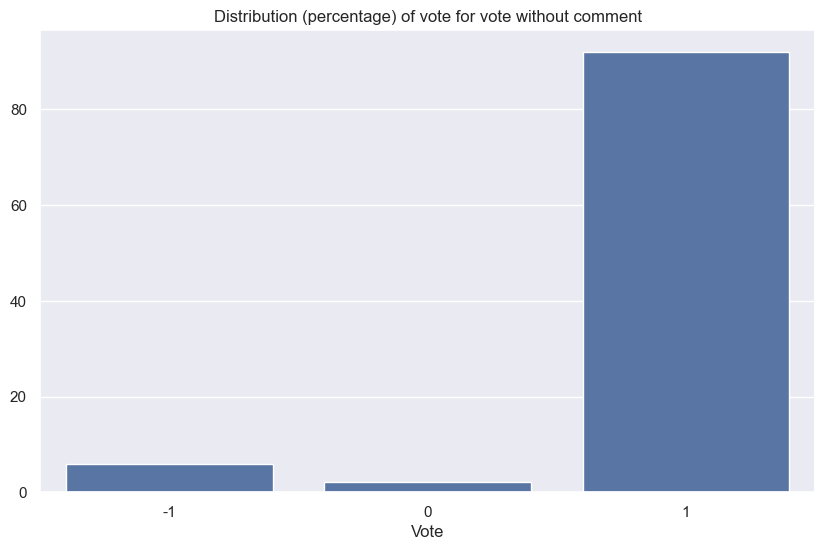

In [134]:
dist_vote_no_comment= zero_word['Vote'].value_counts(normalize=True)*100
sns.barplot(x=dist_vote_no_comment.index, y=dist_vote_no_comment.values)
plt.title('Distribution (percentage) of vote for vote without comment')
plt.show()

Indeed we obtain a large majority of positive vote.

#### 7.2.2 Vote with one comment <a class="anchor" id="vote_with_one_comment"></a>
We conduct the same analysis as for no-comment vote.

In [135]:
one_word = stat_df[stat_df['Vector_Size']==1]

print(f"Proportion of comment of one word {len(one_word['Vector_Size'])/len(stat_df['Vector_Size'])*100:.2f}%")

Proportion of comment of one word 8.84%


As for vote without any comment, we could expect that votes with one word comment are straightforward votes and then we can expect a similar trend to votes without comments

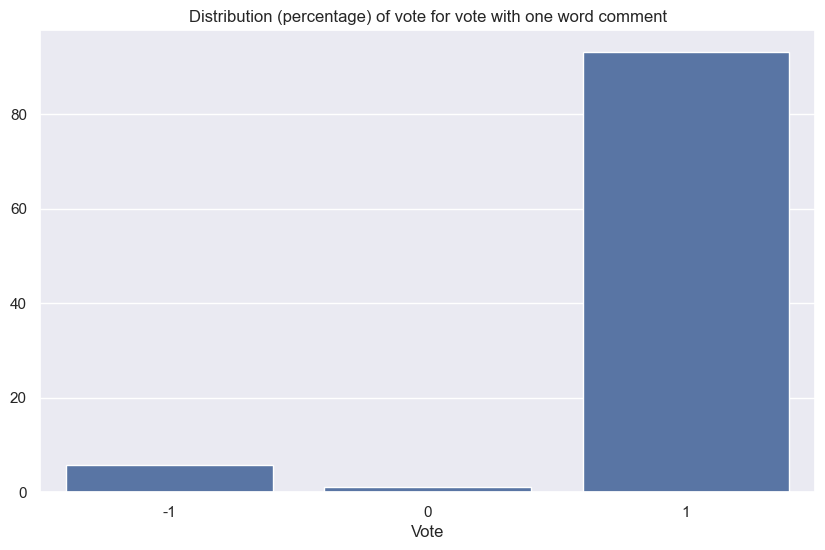

In [136]:
dist_vote_one_word_comment= one_word['Vote'].value_counts(normalize=True)*100
sns.barplot(x=dist_vote_one_word_comment.index, y=dist_vote_one_word_comment.values)
plt.title('Distribution (percentage) of vote for vote with one word comment')
plt.show()

In [137]:
df_one_word = pd.DataFrame(np.concatenate(one_word['Vectorized_Comment'].values), columns=['word']) #handle the list of string type for each row
percentage=df_one_word['word'].value_counts(normalize=True)*100
print('Percentage of the 15 first one word comment:')
percentage[:15]

Percentage of the 15 first one word comment:


word
support       77.992948
oppose         4.254581
yes            1.057865
course         1.005838
sure           0.791953
cool           0.739927
neutral        0.734146
absolutely     0.653217
nom            0.450893
small          0.398867
definitely     0.369964
thought        0.352622
certainly      0.323718
fine           0.312157
nominator      0.283253
Name: proportion, dtype: float64

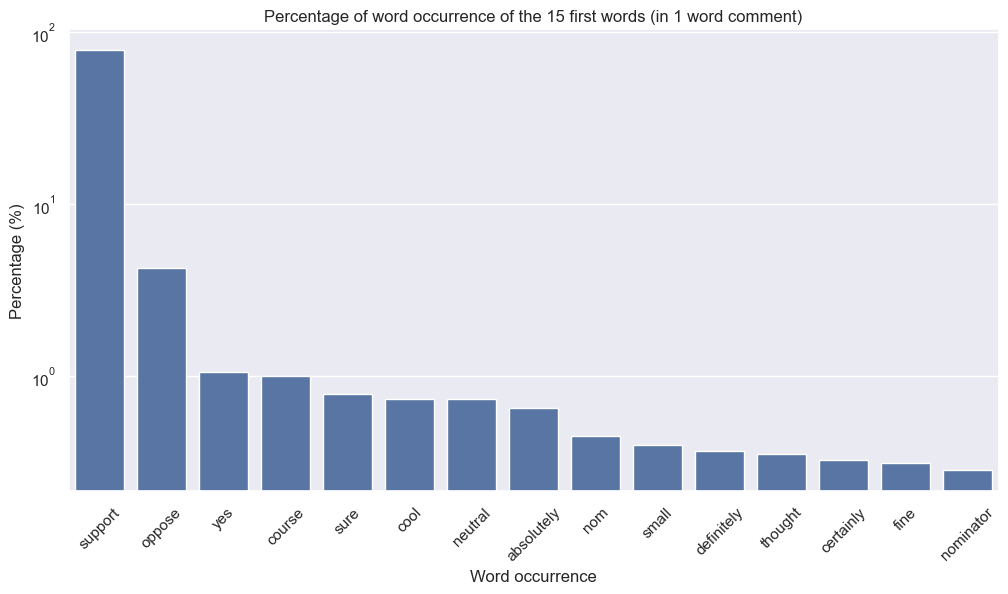

In [138]:
plt.figure(figsize=(12, 6))
sns.barplot(x=percentage[:15].index, y=percentage[:15].values)
plt.xticks(rotation=45)
plt.yscale('log')
plt.xlabel('Word occurrence')
plt.ylabel('Percentage (%)')
plt.title('Percentage of word occurrence of the 15 first words (in 1 word comment)')
plt.show()

#### 7.2.3 Vote with two comments <a class="anchor" id="vote_with_two_comments"></a>
We conduct the same analysis as for no-comment and one comment votes.

In [139]:
two_words = stat_df[stat_df['Vector_Size']==2]

First we look at word independently, it means that for each comment we consider that the 2 words are not related

In [140]:
#Look at words individually
df_two_words = pd.DataFrame(np.concatenate(two_words['Vectorized_Comment'].values), columns=['word']) 
percentage_2words_ind=df_two_words['word'].value_counts(normalize=True)*100
print('Percentage of the 15 first words when looking at 2 words comment and considering each word independently')
percentage_2words_ind[:15]

Percentage of the 15 first words when looking at 2 words comment and considering each word independently


word
support       35.461490
oppose         5.534768
nom            3.886031
strong         2.506236
course         1.952760
nominator      1.590271
concerns       1.403181
good           1.325226
problems       1.321328
reason         1.223885
yes            1.114749
neutral        0.900374
sure           0.787340
fine           0.717181
definitely     0.713283
Name: proportion, dtype: float64

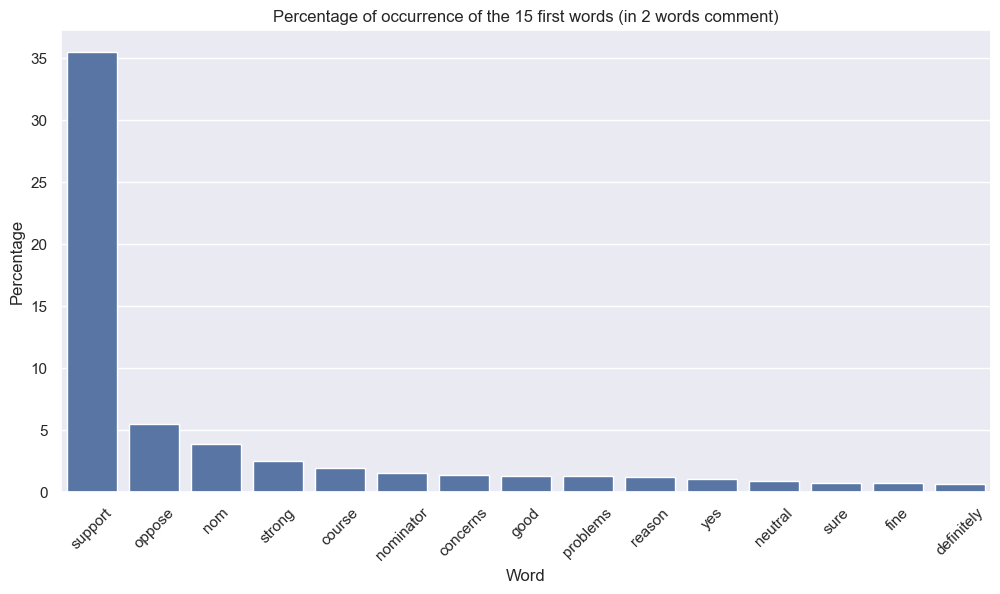

In [141]:
plt.figure(figsize=(12, 6))
sns.barplot(x=percentage_2words_ind[:15].index, y=percentage_2words_ind[:15].values)
plt.xticks(rotation=45)
#plt.yscale('log')
plt.xlabel('Word')
plt.ylabel('Percentage')
plt.title('Percentage of occurrence of the 15 first words (in 2 words comment)')
plt.show()

Since taking word independently does not allow to take into account the context, we look at comment with the 2 words together. 

In [142]:
#Look at pair of word
#order word to be able to compare them
df_paired_2words = pd.DataFrame(two_words['Vectorized_Comment'].values, columns=['word'])
df_paired_2words['word'] = df_paired_2words['word'].apply(lambda x: sorted(x))

paired_2words_percentage=df_paired_2words['word'].value_counts(normalize=True)*100
print('Percentage of the 15 first pair of words when looking at 2 word comment')
paired_2words_percentage[:15]

Percentage of the 15 first pair of words when looking at 2 word comment


word
[nom, support]           7.530402
[strong, support]        4.248519
[course, support]        3.476770
[nominator, support]     2.970065
[problems, support]      2.525725
[concerns, support]      2.400998
[reason, support]        2.198316
[support, yes]           1.333022
[definitely, support]    1.262862
[support, sure]          1.255067
[absolutely, support]    1.153726
[fine, support]          1.083567
[support, thought]       1.067976
[issues, support]        0.943249
[support, tere]          0.935454
Name: proportion, dtype: float64

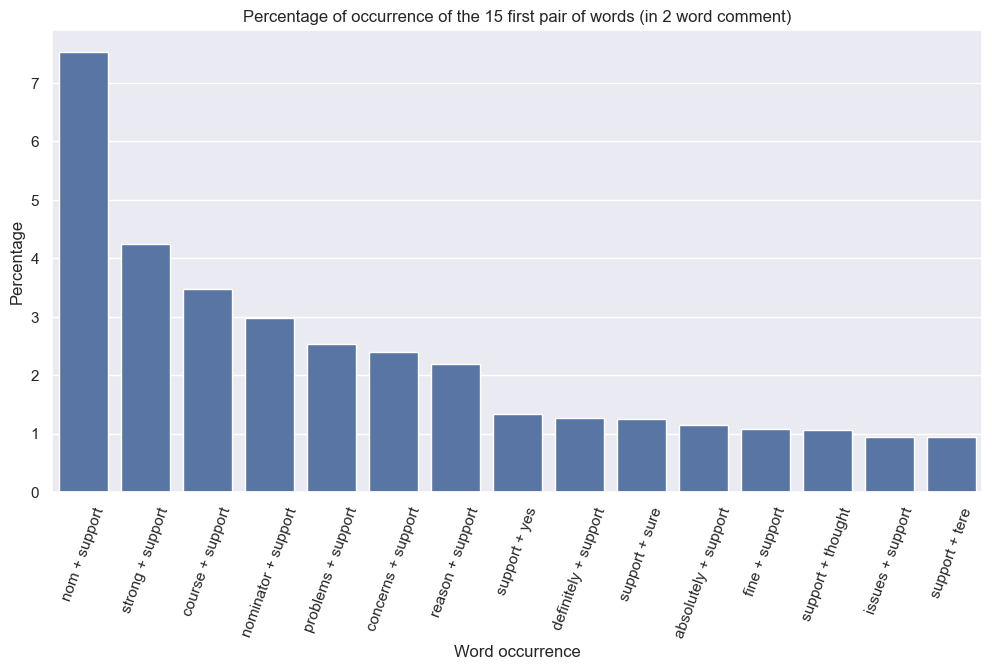

In [143]:
#convert values of x axis with the correct type for the plot
paired_strings = [' + '.join(pair) for pair in paired_2words_percentage.index]

plt.figure(figsize=(12, 6))
sns.barplot(x=paired_strings[:15], y=paired_2words_percentage[:15].values)
plt.xticks(rotation=70)
#plt.yscale('log')
plt.xlabel('Word occurrence')
plt.ylabel('Percentage')
plt.title('Percentage of occurrence of the 15 first pair of words (in 2 word comment)')
plt.show()

Generally speaking, we can see that the word "Support" is dominant in all comments of size 1 or 2. The word "oppose" appears with a high proportion for comments of one word and 2 words treated independently, whereas this is not the case for the treatment of pairs of 2 words. We would expect to see the same pattern when all the words in the comments are taken into account.

#### 7.2.4 Most frequently used words (all comments) <a class="anchor" id="most_frequent_words"></a>

Creates word array for all small dataframe

In [144]:
#Split the dataframe to avoid memory problem (may not be necessary)
list_of_dataframes = np.array_split(stat_df, 100)

word_array=[]
tot_nbr_words=0
for n in range(len(list_of_dataframes)):
    df_comment=pd.DataFrame(np.concatenate(list_of_dataframes[n]['Vectorized_Comment'].values), columns=['word'])
    word_array.append(df_comment)
    tot_nbr_words += len(df_comment['word'])

Count the number of word for each occurence

In [145]:
def compute_sum_word(df):
    return df['word'].value_counts()
count = list(map(compute_sum_word, word_array))

Merge result

In [146]:
#concatenate all word-occurrence for all array
all_words_df = pd.concat(count, axis=1).T
#compute the percentage of occurrence for all words present in the comment
percentage_word = all_words_df.sum(axis=0)/tot_nbr_words*100
#order for the plot
ordered_percentage_word= percentage_word.sort_values(ascending=False)

Plots results

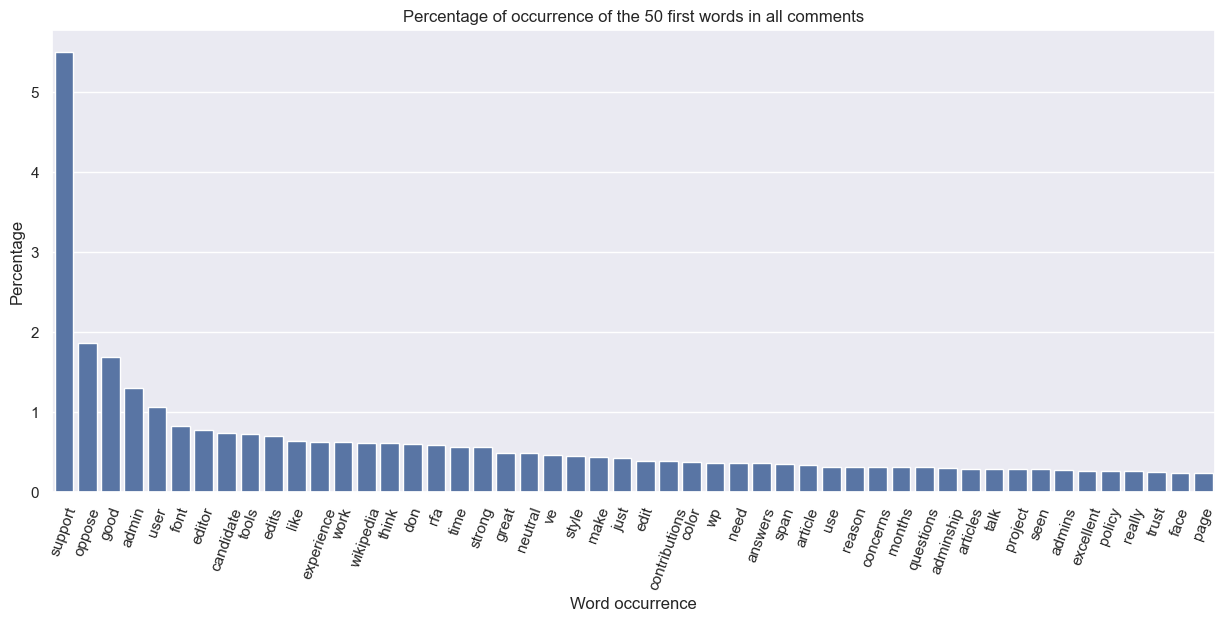

In [147]:
plt.figure(figsize=(15, 6))
sns.barplot(x=ordered_percentage_word[:50].index, y=ordered_percentage_word[:50].values)
plt.xticks(rotation=70)
plt.xlabel('Word occurrence')
plt.ylabel('Percentage')
plt.title('Percentage of occurrence of the 50 first words in all comments')
plt.show()

As expected we have the words "support" and "oppose" as the most dominant word in all comments.

#### 7.2.5 Plots the result distribution of the comment length <a class="anchor" id="comment_length"></a>

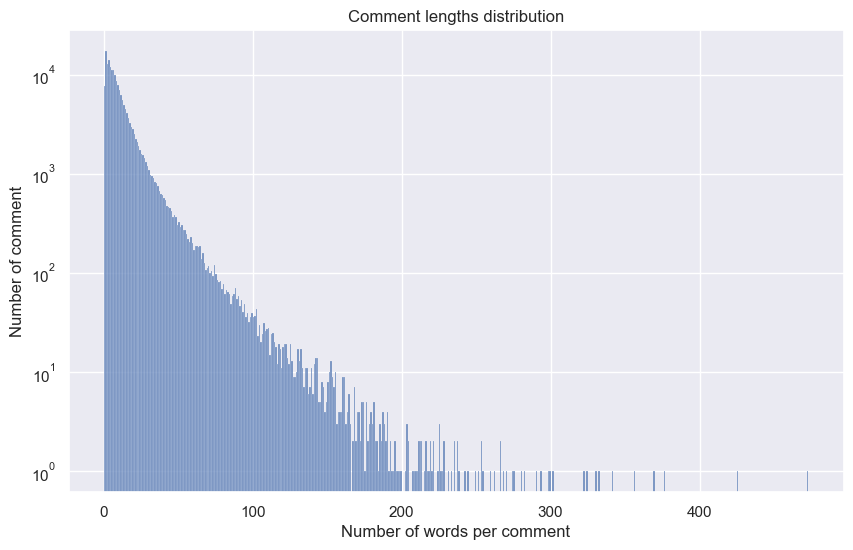

In [148]:
sns.histplot(stat_df['Vector_Size'],binwidth=1, kde=False)  
plt.title('Comment lengths distribution')
plt.xlabel('Number of words per comment')
plt.ylabel('Number of comment')
plt.yscale('log')
plt.show()

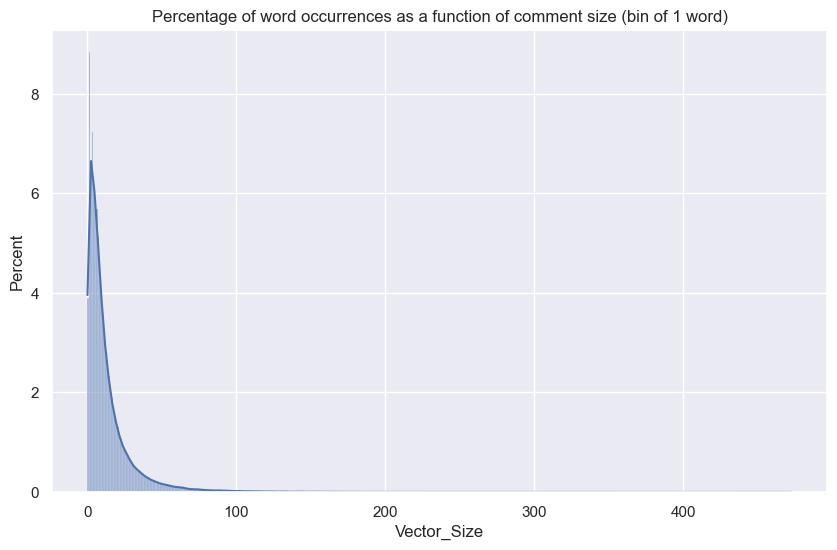

In [149]:
sns.histplot(data=stat_df, x='Vector_Size', kde=True, binwidth=1, stat='percent') 
plt.title('Percentage of word occurrences as a function of comment size (bin of 1 word)')
plt.show()

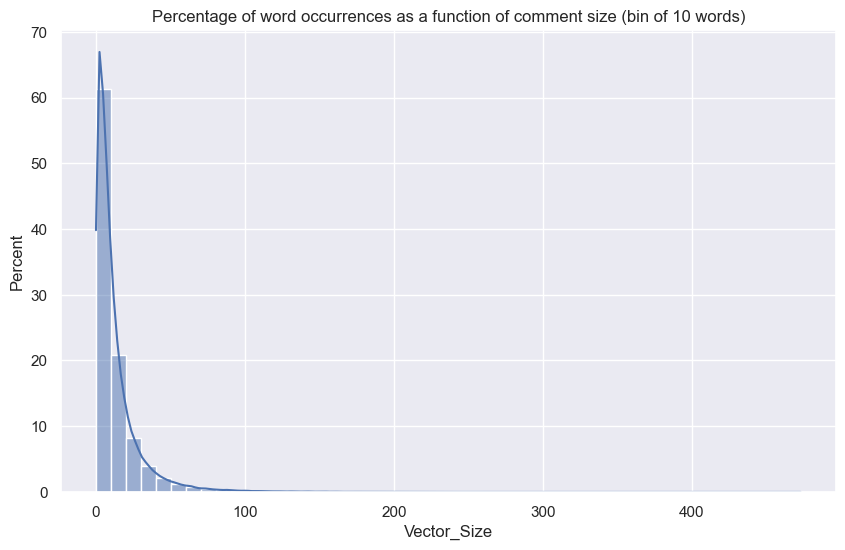

In [150]:
sns.histplot(data=stat_df, x='Vector_Size', kde=True, binwidth=10, stat='percent') #j'ai pris arbitrairement 10 mots
plt.title('Percentage of word occurrences as a function of comment size (bin of 10 words)')
plt.show()

From here we call our best friend - the log - to save us, in order to see something.

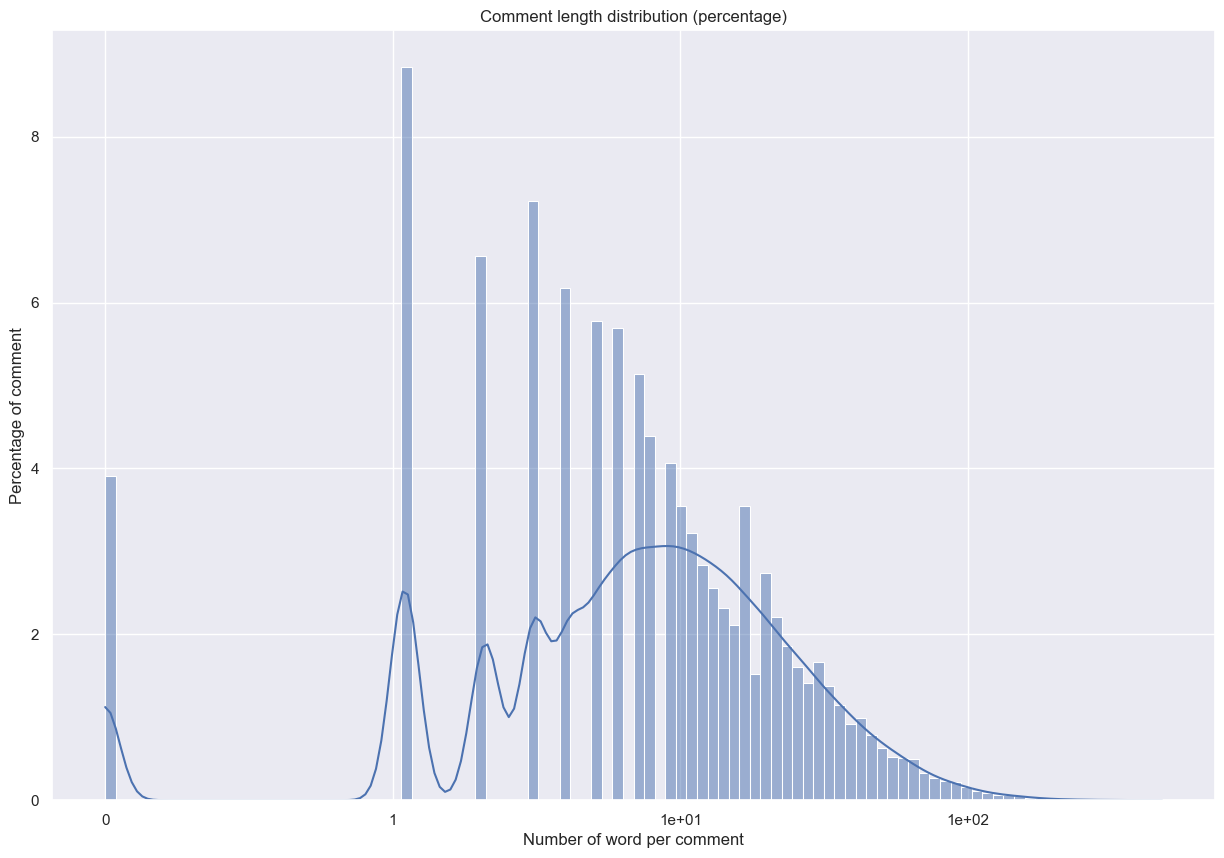

In [151]:
log_shift = 0.1
vector_size_plot = stat_df.Vector_Size + log_shift

fig, ax = plt.subplots(figsize=(15,10))
sns.histplot(data=vector_size_plot, kde=True, stat='percent', log_scale=(True, False), bins=100, ax=ax) #j'ai pris 10 arbitrairement, à changer au besoin
ax.set_title('Comment length distribution (percentage)')
ax.set_xlabel('Number of word per comment')
ax.set_ylabel('Percentage of comment')
ax.set_xscale('log')
ticks = np.power(10, np.arange(np.log10(log_shift), np.ceil(np.log10(np.max(vector_size_plot))), 1))
labels = [f'{tick:.0e}' for tick in ticks]
labels[0] = '0'
labels[1] = '1'
ax.set_xticks(ticks, labels=labels)
plt.show()

From these plots we can see that most comments have less than 30 words.

# 8. Extracting more Information about Comments <a class="anchor" id="comment_info"></a>

As in the previous part we will start over with less processed dataset. Moreover here we consider similarities Target-wise but we could also do the following analysis election-wise. 

In [152]:
df_cosine_similarity = pd.read_csv('wiki-RfA.csv', index_col=0, parse_dates=['Date'])

#Parse the comments to a new column
df_cosine_similarity['Comment'] = df_cosine_similarity['Comment'].apply(lambda x: [] if pd.isna(x) else x)
df_cosine_similarity["Parsed_Comment"] = df_cosine_similarity.Comment.apply(lambda x: mwparserfromhell.parse(x).strip_code())

df_cosine_similarity.sample(3)

,Source,Target,Vote,Results,Year,Date,Comment,Parsed_Comment
197787,Ugen64,Sam Spade,1,-1,2004,NaT,I have had many conversations with this user o...,I have had many conversations with this user o...
38560,Shanata,Materialscientist,1,1,2009,2009-10-21 04:03:00,'''Support''' per nominator. Materialscientis...,Support per nominator. Materialscientist does...
145560,Rogerd,Quarl,1,1,2006,2006-02-03 02:44:00,'''Support''' Good editor --,Support Good editor --


### 8.1 Cosinus Similarity <a class="anchor" id="cosine_similarity"></a>

In [153]:
from sklearn.metrics.pairwise import cosine_similarity

#### 8.1.1 Extracts cosine similarities
Groups by Target the DF, please note that we compute similarity between comments that are targetted to the same Target for performance reason and relevance too. But we computed the TF-IDF vectorization on the whole comment lists. 

In [154]:
#Group by Target
grouped_by_target = df_cosine_similarity.groupby('Target').apply(lambda x: list((enumerate(zip(x['Source'], x['Parsed_Comment'])))))
grouped_by_target = grouped_by_target.apply(lambda x: [(item[1][0], item[0], item[1][1]) for item in x]).reset_index()
grouped_by_target = grouped_by_target.rename(columns={0:'Text'})

#Build UID for all pairs of (SRC, Comment)
global_index = 0
for df_index, row in grouped_by_target.iterrows():
    length_of_current_list = len(row.Text)
    mrange = range(global_index, global_index+length_of_current_list)
    global_index += length_of_current_list
    new_list = [(item[0], idx, item[2]) for item, idx in zip(row.Text, mrange)]
    grouped_by_target.at[df_index, 'Text'] = new_list

#Format to have dictionary to be sure to access things in the right order
grouped_by_target.Text = grouped_by_target.Text.apply(lambda x: {(item[0], item[1]):item[2] for item in x})

#Extracting and flattening of the comments with UID 
comments_list = [row.Text for _, row in  grouped_by_target.iterrows()]
comments_dict = {}
for d in comments_list:
    comments_dict.update(d)

#Compute the tfidf coefficient building the vectors
tfidf_m_sparse = hlp.tf_idf_matrix(comments_dict)

#Reformat the output to be normaly indexable (no need to optimize with sparse matrix)
tfidf_m =  tfidf_m_sparse.todense()

#Match the tfidf vectors to corresponding vectors
grouped_by_target['tfidf_matrix'] = grouped_by_target.Text.apply(lambda x: tfidf_m[hlp.get_idx_lower_bound(x.keys()):hlp.get_idx_upper_bound(x.keys())+1])

#Compute the cosinus similarity
new_rows = []
for index_df, row in grouped_by_target.iterrows():
    target_tfidf_dense_matrix = np.asarray(row.tfidf_matrix)
    target_cos_sim = cosine_similarity(target_tfidf_dense_matrix, target_tfidf_dense_matrix)
    new_rows.append(target_cos_sim)
grouped_by_target["cosine_similarity"] = new_rows

#### 8.1.2 Get some basic statistics on Cosine Similarities

The cosine similarities are stored in one matrix for each target. This matrix is symmetrical and the digonal values are 1 - since a comment is fully similar to itself. So we transform this matrix into dictionnary with keys based on Unique Identifiers as define above.

In [155]:
grouped_by_target['cosine_similarity_by_paires'] = grouped_by_target.cosine_similarity.apply(hlp.generate_cossim_pairs)

Get the whole collection of cosine similarity values from dictionnaries.

In [156]:
collection_of_values = [value for subdic in grouped_by_target.cosine_similarity_by_paires for value in subdic.values()]
mean_cov = np.mean(collection_of_values)
std_cov = np.std(collection_of_values)
median_cov = np.median(collection_of_values)
top_5 = np.percentile(collection_of_values, 95)
top_10 = np.percentile(collection_of_values, 90)
top_15 = np.percentile(collection_of_values, 85)
top_20 = np.percentile(collection_of_values, 80)
top_25 = np.percentile(collection_of_values, 75)
top_1 = np.percentile(collection_of_values, 99)
top_2 = np.percentile(collection_of_values, 98)
top_3 = np.percentile(collection_of_values, 97)
top_4 = np.percentile(collection_of_values, 96)
print(f"Mean: {mean_cov:.2f}")
print(f"Std: {std_cov:.2f}")
print(f"Median: {median_cov:.2f}")

Mean: 0.04
Std: 0.10
Median: 0.01


Plots the histogram of cosinus similarity values

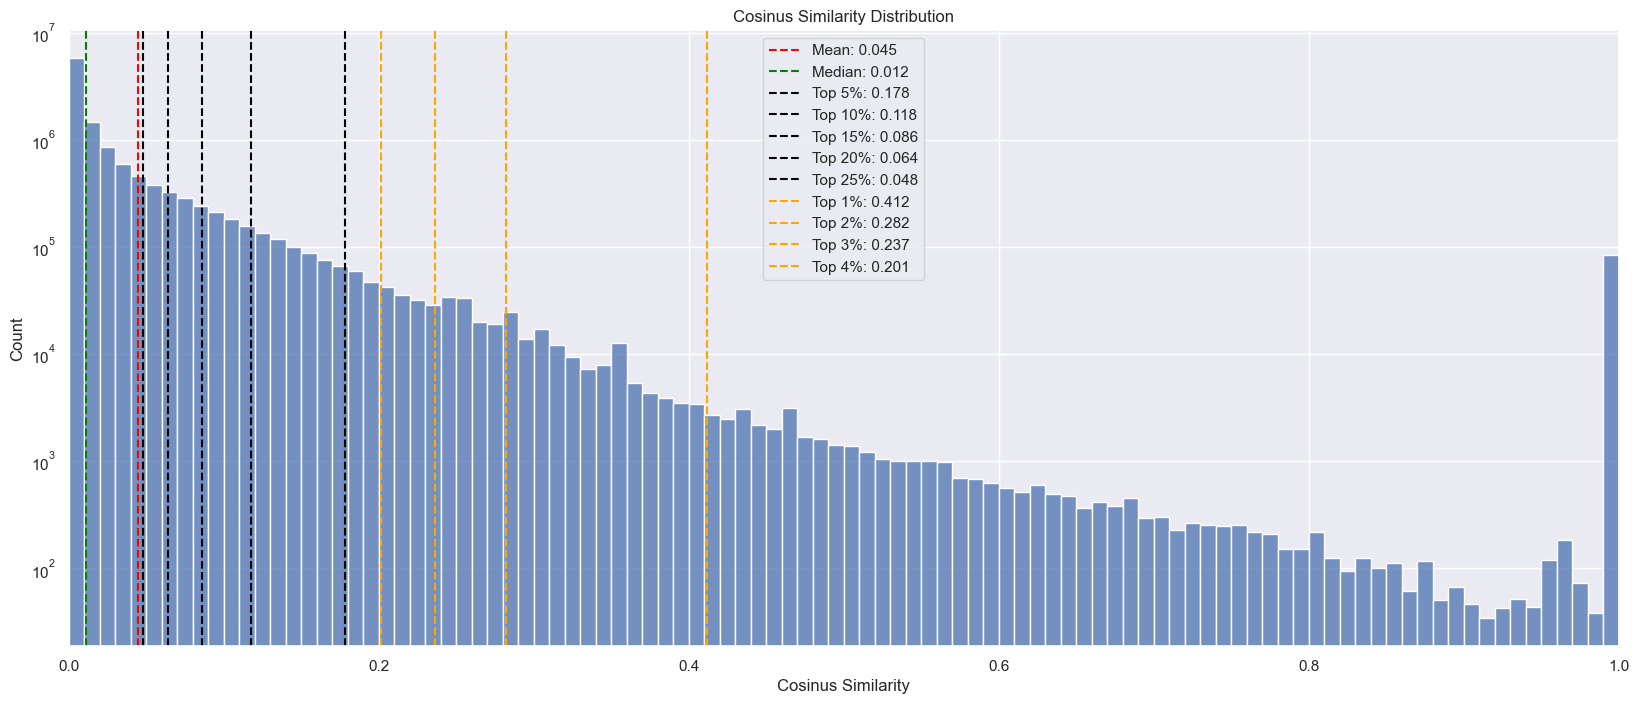

In [157]:
plt.figure(figsize=(20, 8))
sns.histplot(collection_of_values, bins=100, kde=False)

plt.yscale('log')
plt.xlim(0, 1)

plt.axvline(x=mean_cov, color='red', linestyle='--', label=f'Mean: {mean_cov:.3f}')
plt.axvline(x=median_cov, color='green', linestyle='--', label=f'Median: {median_cov:.3f}')

plt.axvline(x=top_5, color='black', linestyle='--', label=f'Top 5%: {top_5:.3f}')
plt.axvline(x=top_10, color='black', linestyle='--', label=f'Top 10%: {top_10:.3f}')
plt.axvline(x=top_15, color='black', linestyle='--', label=f'Top 15%: {top_15:.3f}')
plt.axvline(x=top_20, color='black', linestyle='--', label=f'Top 20%: {top_20:.3f}')
plt.axvline(x=top_25, color='black', linestyle='--', label=f'Top 25%: {top_25:.3f}')

plt.axvline(x=top_1, color='orange', linestyle='--', label=f'Top 1%: {top_1:.3f}')
plt.axvline(x=top_2, color='orange', linestyle='--', label=f'Top 2%: {top_2:.3f}')
plt.axvline(x=top_3, color='orange', linestyle='--', label=f'Top 3%: {top_3:.3f}')
plt.axvline(x=top_4, color='orange', linestyle='--', label=f'Top 4%: {top_4:.3f}')

plt.title("Cosinus Similarity Distribution")
plt.xlabel("Cosinus Similarity")
plt.ylabel("Count")

plt.legend()
plt.show()

We can see that an extremly large majority of the similarites are below 0.5 which can be great to discrimine between comments. But there is also a peak around 1.0 and these comments are likely to be the shortest ones with "support" and "oppose" as main parts of them.